In [1]:
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.utils import *
from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *
import graph_tool.all as gt

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_context("talk")

In [3]:
# >=5 syn threshold was applied to this data already
ver = 630
fdir = "data/connections.csv"
syn_table = pd.read_csv(fdir)

In [4]:
syn_table.head()

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940596125868,720575940608552405,LOP_R,5,ACH
1,720575940596125868,720575940611348834,LOP_R,7,ACH
2,720575940596125868,720575940613059993,LOP_R,5,GLUT
3,720575940596125868,720575940616986553,LOP_R,5,ACH
4,720575940596125868,720575940620124326,LOP_R,8,ACH


### 0. Graph Construction

In [5]:
# build index dictionary
cellids =  np.unique(syn_table[["pre_root_id", "post_root_id"]])
nid2cid = {i: cid for i, cid in enumerate(cellids)}
cid2nid = {cid: i for i, cid in enumerate(cellids)}

In [6]:
syn_table["pre_nid"] = pd.Series([cid2nid[cid] for cid in syn_table["pre_root_id"]], 
                                 index=syn_table.index)
syn_table["post_nid"] = pd.Series([cid2nid[cid] for cid in syn_table["post_root_id"]], 
                                 index=syn_table.index)

In [7]:
merged_syn_table = syn_table[["pre_nid", "post_nid", "syn_count"]
                           ].groupby(by=["pre_nid", "post_nid"]).sum().reset_index()

In [8]:
merged_edge_list = [(e[0], e[1], e[2]) for e in merged_syn_table.values]

In [9]:
g = gt.Graph()
g.add_vertex(len(cellids))
e_syn_count = g.new_ep("int32_t")
g.add_edge_list(merged_edge_list, eprops=[e_syn_count])
g.vp["cellid"] = g.new_vp("int64_t")
g.vp["cellid"].a = cellids
g.ep["syn_count"] = e_syn_count

In [10]:
# merged weightedd graph
g

<Graph object, directed, with 124891 vertices and 2613129 edges, 1 internal vertex property, 1 internal edge property, at 0x2e0512910>

In [11]:
syn_table

,pre_root_id,post_root_id,neuropil,syn_count,nt_type,pre_nid,post_nid
0,720575940596125868,720575940608552405,LOP_R,5,ACH,0,5720
1,720575940596125868,720575940611348834,LOP_R,7,ACH,0,10418
2,720575940596125868,720575940613059993,LOP_R,5,GLUT,0,15107
3,720575940596125868,720575940616986553,LOP_R,5,ACH,0,27102
4,720575940596125868,720575940620124326,LOP_R,8,ACH,0,39200
...,...,...,...,...,...,...,...
3794610,720575940660868737,720575940607206786,ME_L,9,GABA,124890,4138
3794611,720575940660868737,720575940608664873,ME_L,6,GABA,124890,5890
3794612,720575940660868737,720575940611462242,ME_L,6,GABA,124890,10700
3794613,720575940660868737,720575940622913063,ME_L,23,GABA,124890,53880


In [12]:
def weighted_majority(group):
    # Calculating weighted counts
    weighted_counts = group.groupby('neuropil')['syn_count'].sum()
    # Returning the neuropil with the highest weighted count
    return weighted_counts.idxmax()

cell_neuropil_assignment = syn_table.groupby('pre_root_id').apply(weighted_majority).reset_index(name='majority_neuropil')

In [13]:
neuropils = list(np.unique(cell_neuropil_assignment['majority_neuropil']))
np2npid = {name: i for i, name in enumerate(neuropils)}

In [14]:
cid2npid = dict(zip(cell_neuropil_assignment['pre_root_id'], cell_neuropil_assignment['majority_neuropil'].map(np2npid).values))

In [15]:
def get_npid(v):
    if v in cid2npid.keys():
        return cid2npid[v]
    else:
        return -1

In [16]:
g.vp["neuropil_id"] = g.new_vp("int32_t")

In [17]:
g.vp["neuropil_id"].a = np.array([get_npid(v) for v in np.array(g.vp['cellid'].a)])

In [21]:
g.vp["neuropil_id"].a[g.vp["neuropil_id"].a == -1] = g.vp["neuropil_id"].a.max() + 1

In [22]:
neuropil_block = gt.BlockState(g, g.vp["neuropil_id"])

In [23]:
rich_club_coefficients = {}

In [24]:
colors = {"obs": '#993333',
          "cfg": '#669966',
          "rel-cfg": '#003366',
          'npc': '#cc6633',
          'rel-npc': '#805D80'}

## 1. Total-degree rich-club

### 1.1 Observed Network

In [25]:
%%time
total_degrees = g.degree_property_map("total") 
degrees = sorted(np.unique(total_degrees.a))

# Create a list to store the rich club coefficients
rich_club_coefficients["total"] = []

# Compute the rich club coefficients for each value of k
for k in tqdm(degrees):
    subgraph = gt.GraphView(g, vfilt=(total_degrees.a >= k))
    m = subgraph.num_edges()
    nk = subgraph.num_vertices()
    if m > 0:
        k_edges = (nk * (nk - 1))
        rich_club_coefficients["total"].append(m / k_edges)
    else:
        rich_club_coefficients["total"].append(0)

  0%|          | 0/792 [00:00<?, ?it/s]

CPU times: user 11.5 s, sys: 315 ms, total: 11.8 s
Wall time: 11.9 s


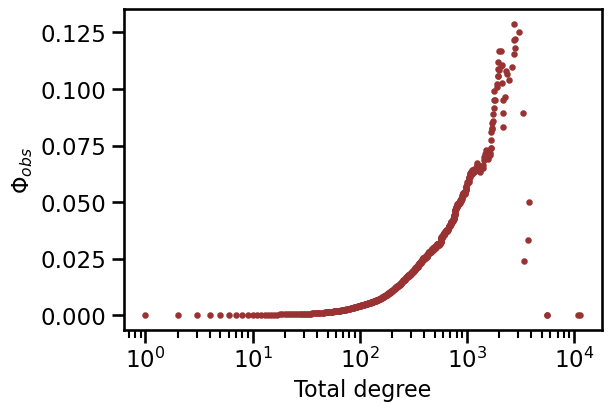

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
ax.scatter(degrees, rich_club_coefficients["total"], s=10, color=colors['obs'])
ax.set_xscale('log')
ax.set_xlabel('Total degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$', fontsize=16)
plt.savefig("figs/total-degree-phi-obs.pdf", transparent=True)

### 1.2 Configuration model (no self-loops, no parallel edges)

In [27]:
%%time
REPEAT = 10

rich_club_coefficients["total-cfg"] = []
g_rand = g.copy()

# Create a list to store the rich club coefficients
for rp in tqdm(range(REPEAT)):
    gt.random_rewire(g_rand, parallel_edges=False, self_loops=False)
    total_degrees = g_rand.degree_property_map("total") 
    degrees = sorted(np.unique(total_degrees.a))

    # Compute the rich club coefficients for each value of k
    for k in tqdm(degrees):
        subgraph = gt.GraphView(g_rand, vfilt=(total_degrees.a >= k))
        m = subgraph.num_edges()
        nk = subgraph.num_vertices()
        if m > 0:
            k_edges = (nk * (nk - 1))
            rich_club_coefficients["total-cfg"].append(m / k_edges)
        else:
            rich_club_coefficients["total-cfg"].append(0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

CPU times: user 1min 34s, sys: 6.74 s, total: 1min 41s
Wall time: 1min 41s


In [28]:
rich_club_coefficients["total-cfg"] = np.array(rich_club_coefficients["total-cfg"]).reshape(10, -1)

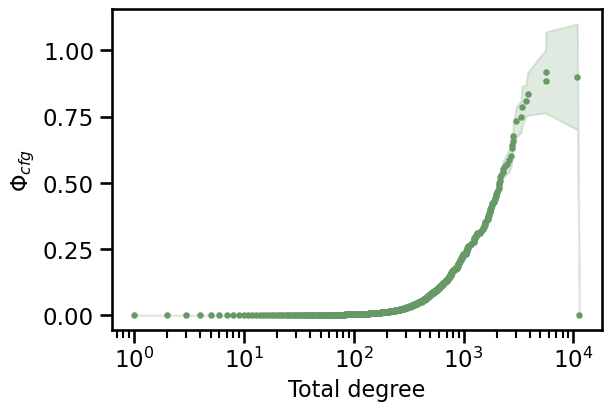

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["total-cfg"], axis=0)
stddevs = np.std(rich_club_coefficients["total-cfg"], axis=0)
ax.scatter(degrees, means, s=10, color=colors['cfg'])
ax.fill_between(degrees, means - stddevs, means + stddevs, color=colors['cfg'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('Total degree', fontsize=16)
ax.set_ylabel('$\Phi_{cfg}$', fontsize=16)
plt.savefig("figs/total-degree-phi-cfg.pdf", transparent=True)

### 1.3 Neuropil Constrained Model

In [30]:
block_matrix = neuropil_block.get_matrix()
block_n = neuropil_block.get_nr()

<VertexPropertyMap object with value type 'int32_t', for Graph 0x2919ffd10, at 0x2919e0dd0>


In [124]:
block_n.a.min(), block_n.a.max()

(PropertyArray(2, dtype=int32), PropertyArray(19885, dtype=int32))

In [123]:
np.unique(g.vp['neuropil_id'].a, return_counts=True)

(PropertyArray([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
                15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
                45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
                60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
                75, 76, 77, 78, 79], dtype=int32),
 array([ 1535,  1225,     5,     9,   123,   221,   541,   583,    44,
           33,  1626,  2003,    24,    37,     5,     2,   499,   659,
          392,     8,     4,  1696,   129,   185,    12,     4,  4979,
           63,    55,   193,   198,   583,   593,   792,   742,   543,
          542,   732,  1437,   799,   739,  6713,  7250, 11118, 10898,
          123,   108,  2276,  1453,   158,   276,   149,   727, 18228,
        19885,   275,   182,    97,  1420,  1248,   532,  1273,  1042,
          700,   197,   177,   206,   304,  1651,  1892,  1738,  1900,
 

In [31]:
block_prob_matrix =  block_matrix.todense() / np.outer(block_n.a, block_n.a)
block_prob = lambda r, s: block_prob_matrix[r, s]

In [32]:
%%time
REPEAT = 10

rich_club_coefficients["total-npc"] = []
g_rand = g.copy()

# Create a list to store the rich club coefficients
for rp in tqdm(range(REPEAT)):
    gt.random_rewire(g_rand, model='blockmodel-degree', parallel_edges=False, self_loops=False, 
                     edge_probs = block_prob,
                     block_membership=g_rand.vp["neuropil_id"])
    total_degrees = g_rand.degree_property_map("total") 
    degrees = sorted(np.unique(total_degrees.a))

    # Compute the rich club coefficients for each value of k
    for k in tqdm(degrees):
        subgraph = gt.GraphView(g_rand, vfilt=(total_degrees.a >= k))
        m = subgraph.num_edges()
        nk = subgraph.num_vertices()
        if m > 0:
            k_edges = (nk * (nk - 1))
            rich_club_coefficients["total-npc"].append(m / k_edges)
        else:
            rich_club_coefficients["total-npc"].append(0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

CPU times: user 1min 22s, sys: 5.76 s, total: 1min 28s
Wall time: 1min 27s


In [33]:
rich_club_coefficients["total-npc"] = np.array(rich_club_coefficients["total-npc"]).reshape(REPEAT, -1)

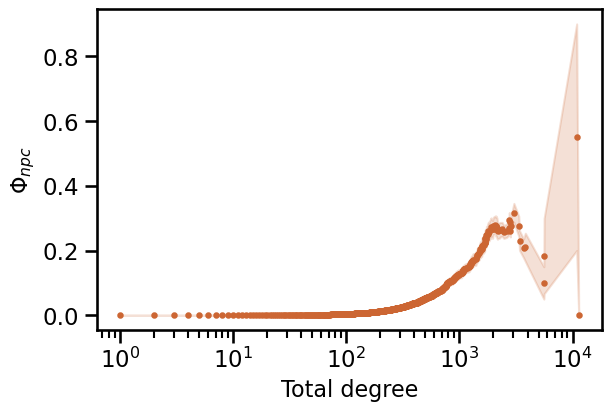

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["total-npc"], axis=0)
stddevs = np.std(rich_club_coefficients["total-npc"], axis=0)
ax.scatter(degrees, means, s=10, color=colors['npc'])
ax.fill_between(degrees, means - stddevs, means + stddevs, color=colors['npc'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('Total degree', fontsize=16)
ax.set_ylabel('$\Phi_{npc}$', fontsize=16)
plt.savefig("figs/total-degree-phi-npc.pdf", transparent=True)

### 1.4 more plots for comparison

obs vs cfg

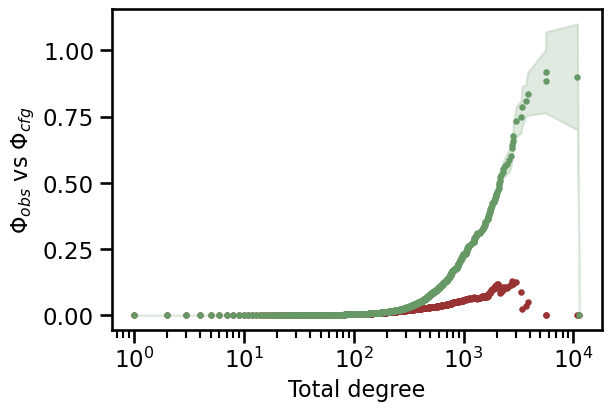

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["total-cfg"], axis=0)
stddevs = np.std(rich_club_coefficients["total-cfg"], axis=0)
ax.scatter(degrees, rich_club_coefficients["total"], s=10, color=colors['obs'])
ax.scatter(degrees, means, s=10, color=colors['cfg'])
ax.fill_between(degrees, means - stddevs, means + stddevs, color=colors['cfg'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('Total degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ vs $\Phi_{cfg}$', fontsize=16)
plt.savefig("figs/total-degree-phi-obs-vs-cfg.pdf", transparent=True)

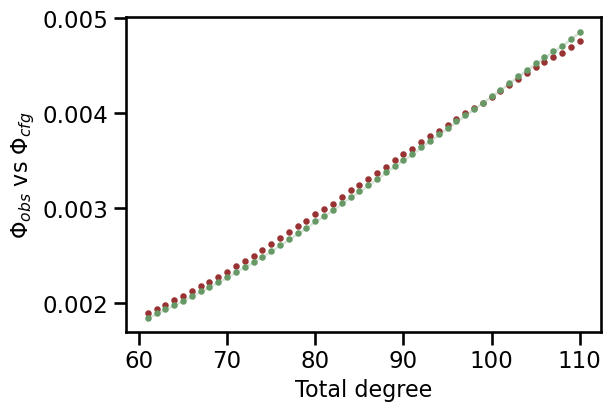

In [36]:
truncation = 110
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["total-cfg"], axis=0)[60:truncation]
stddevs = np.std(rich_club_coefficients["total-cfg"], axis=0)[60:truncation]
ax.scatter(degrees[60:truncation], rich_club_coefficients["total"][60:truncation], s=10, color=colors['obs'])
ax.scatter(degrees[60:truncation], means, s=10, color=colors['cfg'])
ax.fill_between(degrees[60:truncation], means - stddevs, means + stddevs, color=colors['cfg'], alpha=0.2)  # Shaded std dev
ax.set_xlabel('Total degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ vs $\Phi_{cfg}$', fontsize=16)
plt.savefig("figs/total-degree-phi-obs-vs-cfg-truncated.pdf", transparent=True)

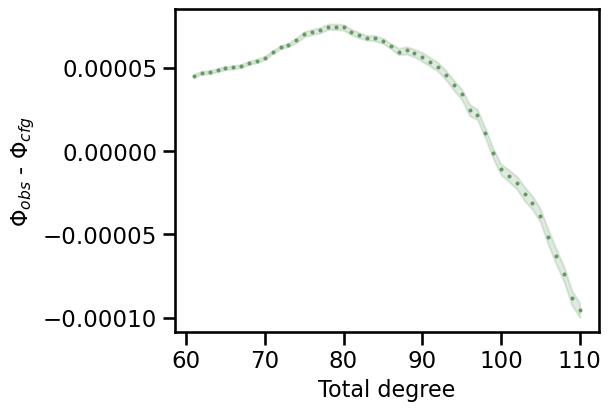

In [37]:
truncation = 110
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
diff = -(rich_club_coefficients["total-cfg"] - np.array(rich_club_coefficients["total"]))
means = np.mean(diff, axis=0)[60:truncation]
stddevs = np.std(diff, axis=0)[60:truncation]
ax.scatter(degrees[60:truncation], means, s=2, color=colors['cfg'])
ax.fill_between(degrees[60:truncation], means - stddevs, means + stddevs, color=colors['cfg'], alpha=0.2)  # Shaded std dev
ax.set_xlabel('Total degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ - $\Phi_{cfg}$', fontsize=16)
plt.savefig("figs/total-degree-phi-obs-diff-cfg-truncated.pdf", transparent=True)

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/1922131756.py:4: RuntimeWarning: invalid value encountered in divide
  rel_phi = obs_mean / means
/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/1922131756.py:5: RuntimeWarning: invalid value encountered in divide
  stddevs = np.std(obs_mean / rich_club_coefficients["total-cfg"], axis=0)


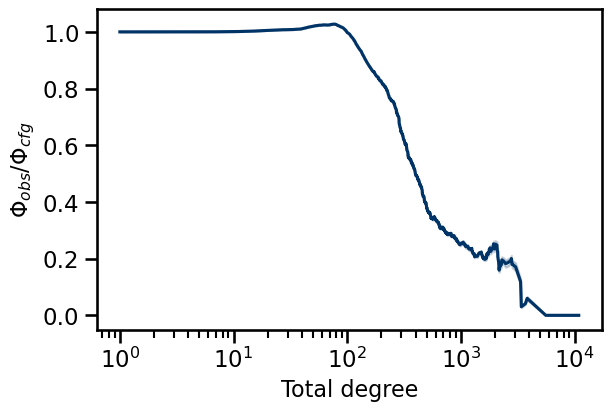

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
obs_mean = np.array(rich_club_coefficients["total"])
means = np.mean(rich_club_coefficients["total-cfg"], axis=0)
rel_phi = obs_mean / means
stddevs = np.std(obs_mean / rich_club_coefficients["total-cfg"], axis=0)
ax.plot(degrees, rel_phi, color=colors['rel-cfg'])
ax.fill_between(degrees, rel_phi - stddevs, rel_phi + stddevs, color=colors['rel-cfg'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('Total degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs} / \Phi_{cfg}$', fontsize=16)
plt.savefig("figs/total-degree-phi-rel-cfg.pdf", transparent=True)

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/3979678147.py:5: RuntimeWarning: invalid value encountered in divide
  rel_phi = (obs_mean / means)[:truncation]
/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/3979678147.py:6: RuntimeWarning: invalid value encountered in divide
  stddevs = np.std(obs_mean / rich_club_coefficients["total-cfg"], axis=0)[:truncation]


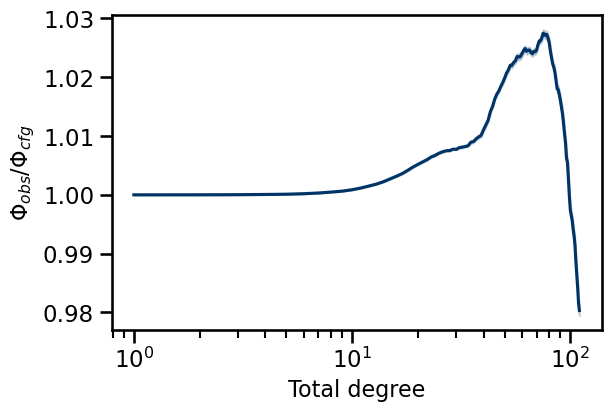

In [39]:
truncation = 110
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
obs_mean = np.array(rich_club_coefficients["total"])
means = np.mean(rich_club_coefficients["total-cfg"], axis=0)
rel_phi = (obs_mean / means)[:truncation]
stddevs = np.std(obs_mean / rich_club_coefficients["total-cfg"], axis=0)[:truncation]
ax.plot(degrees[:truncation], rel_phi, color=colors['rel-cfg'])
ax.fill_between(degrees[:truncation], rel_phi - stddevs, rel_phi + stddevs, color=colors['rel-cfg'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('Total degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs} / \Phi_{cfg}$', fontsize=16)
plt.savefig("figs/total-degree-phi-rel-cfg-truncated.pdf", transparent=True)

obs vs npc

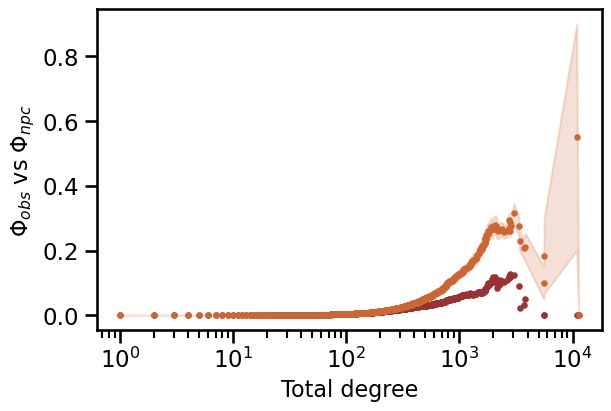

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["total-npc"], axis=0)
stddevs = np.std(rich_club_coefficients["total-npc"], axis=0)
ax.scatter(degrees, rich_club_coefficients["total"], s=10, color=colors['obs'])
ax.scatter(degrees, means, s=10, color=colors['npc'])
ax.fill_between(degrees, means - stddevs, means + stddevs, color=colors['npc'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('Total degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ vs $\Phi_{npc}$', fontsize=16)
plt.savefig("figs/total-degree-phi-obs-vs-npc.pdf", transparent=True)

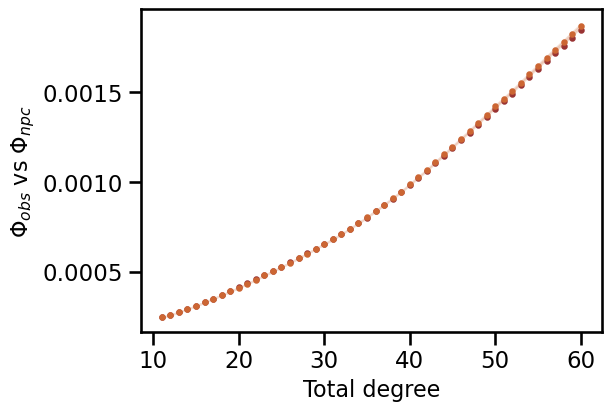

In [41]:
truncation = 60
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["total-npc"], axis=0)[10:truncation]
stddevs = np.std(rich_club_coefficients["total-npc"], axis=0)[10:truncation]
ax.scatter(degrees[10:truncation], rich_club_coefficients["total"][10:truncation], s=10, color=colors['obs'])
ax.scatter(degrees[10:truncation], means, s=10, color=colors['npc'])
ax.fill_between(degrees[10:truncation], means - stddevs, means + stddevs, color=colors['npc'], alpha=0.2)  # Shaded std dev
ax.set_xlabel('Total degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ vs $\Phi_{npc}$', fontsize=16)
plt.savefig("figs/total-degree-phi-obs-vs-npc-truncated.pdf", transparent=True)

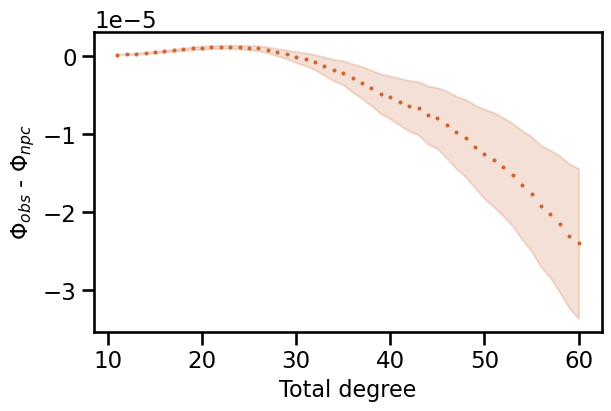

In [42]:
truncation = 60
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
diff = -(rich_club_coefficients["total-npc"] - np.array(rich_club_coefficients["total"]))
means = np.mean(diff, axis=0)[10:truncation]
stddevs = np.std(diff, axis=0)[10:truncation]
ax.scatter(degrees[10:truncation], means, s=2, color=colors['npc'])
ax.fill_between(degrees[10:truncation], means - stddevs, means + stddevs, color=colors['npc'], alpha=0.2)  # Shaded std dev
ax.set_xlabel('Total degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ - $\Phi_{npc}$', fontsize=16)
plt.savefig("figs/total-degree-phi-obs-diff-npc-truncated.pdf", transparent=True)

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/1112198434.py:4: RuntimeWarning: invalid value encountered in divide
  rel_phi = obs_mean / means
/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/1112198434.py:5: RuntimeWarning: invalid value encountered in divide
  stddevs = np.std(obs_mean / rich_club_coefficients["total-npc"], axis=0)


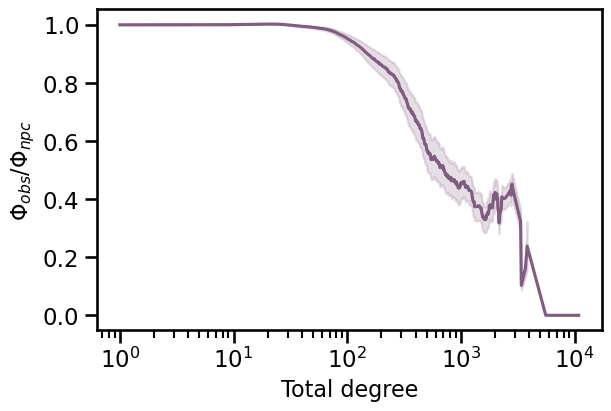

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
obs_mean = np.array(rich_club_coefficients["total"])
means = np.mean(rich_club_coefficients["total-npc"], axis=0)
rel_phi = obs_mean / means
stddevs = np.std(obs_mean / rich_club_coefficients["total-npc"], axis=0)
ax.plot(degrees, rel_phi, color=colors['rel-npc'])
ax.fill_between(degrees, rel_phi - stddevs, rel_phi + stddevs, color=colors['rel-npc'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('Total degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs} / \Phi_{npc}$', fontsize=16)
plt.savefig("figs/total-degree-phi-rel-npc.pdf", transparent=True)

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/1205611766.py:5: RuntimeWarning: invalid value encountered in divide
  rel_phi = (obs_mean / means)[:truncation]
/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/1205611766.py:6: RuntimeWarning: invalid value encountered in divide
  stddevs = np.std(obs_mean / rich_club_coefficients["total-npc"], axis=0)[:truncation]


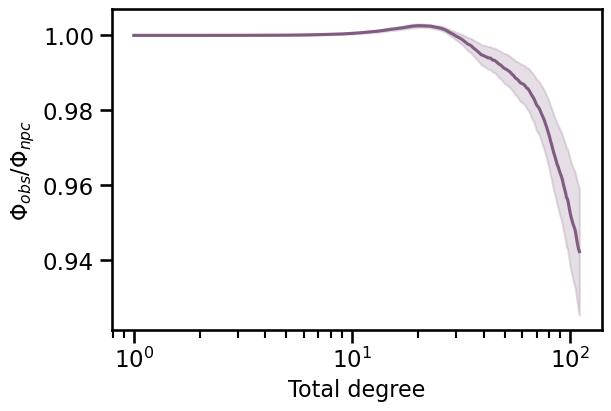

In [44]:
truncation = 110
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
obs_mean = np.array(rich_club_coefficients["total"])
means = np.mean(rich_club_coefficients["total-npc"], axis=0)
rel_phi = (obs_mean / means)[:truncation]
stddevs = np.std(obs_mean / rich_club_coefficients["total-npc"], axis=0)[:truncation]
ax.plot(degrees[:truncation], rel_phi, color=colors['rel-npc'])
ax.fill_between(degrees[:truncation], rel_phi - stddevs, rel_phi + stddevs, color=colors['rel-npc'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('Total degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs} / \Phi_{npc}$', fontsize=16)
plt.savefig("figs/total-degree-phi-rel-npc-truncated.pdf", transparent=True)

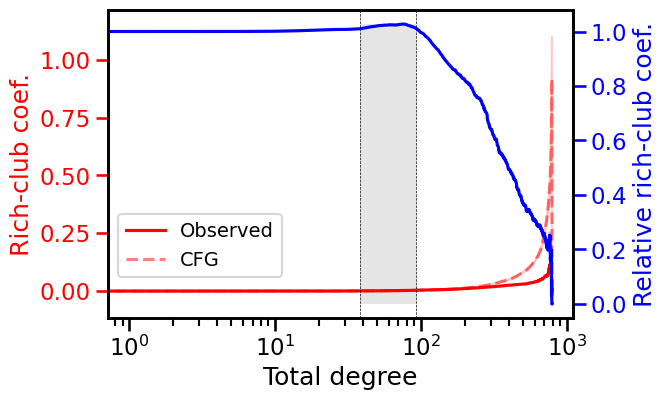

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(rich_club_coefficients["total"], color='red', label="Observed")
ax.plot(np.mean(rich_club_coefficients["total-cfg"], axis=0), linestyle="--", color='red', alpha=0.5, label="CFG")

# Calculate mean and standard deviation
mean = np.mean(rich_club_coefficients["total-cfg"], axis=0)
std = np.std(rich_club_coefficients["total-cfg"], axis=0)

# Plot mean with shadow
ax.fill_between(range(len(mean)), mean - std, mean + std, color='red', alpha=0.2)

ax.set_xlabel("Total degree")
ax.set_xscale('log')
ax.tick_params(axis='y', colors='red')
ax.set_ylabel("Rich-club coef.", color='red')
plt.legend(loc="lower left", bbox_to_anchor=(0.0, 0.1), fontsize=14)

ax2 = ax.twinx()

# Calculate relative rich-club coefficients with standard deviation
relative_rc = np.divide(np.array(rich_club_coefficients["total"]), mean, out=np.zeros_like(mean), where=mean != 0)
relative_rc_std = np.std([np.divide(np.array(rich_club_coefficients["total"]), rich_club_coefficients["total-cfg"][i], 
                      out=np.zeros_like(mean), where=mean != 0) for i in range(5)], axis=0)

ax2.plot(relative_rc, color='blue')
ax2.fill_between(range(len(relative_rc)), relative_rc - relative_rc_std, relative_rc + relative_rc_std, color='blue', alpha=0.2)

ax2.tick_params(axis='y', colors='blue')
ax2.set_ylabel("Relative rich-club coef.", color='blue')

# Add vertical dashed lines where relative_rc > 1
sig_range = np.arange(len(relative_rc))[relative_rc > 1.01]
ax.axvline(sig_range.min(), color='black', linestyle='--', linewidth=0.5)
ax.axvline(sig_range.max(), color='black', linestyle='--', linewidth=0.5)

# Fill the region between the vertical lines with transparent gray
ax.fill_betweenx(ax.get_ylim(), sig_range.min(), sig_range.max(), facecolor='gray', alpha=0.2, edgecolor=None)

plt.savefig('figs/total-degree-cfg-old-style.pdf', transparent=True)

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/1829302544.py:22: RuntimeWarning: invalid value encountered in divide
  relative_rc_std = np.std([np.divide(np.array(rich_club_coefficients["total"]), rich_club_coefficients["total-npc"][i],


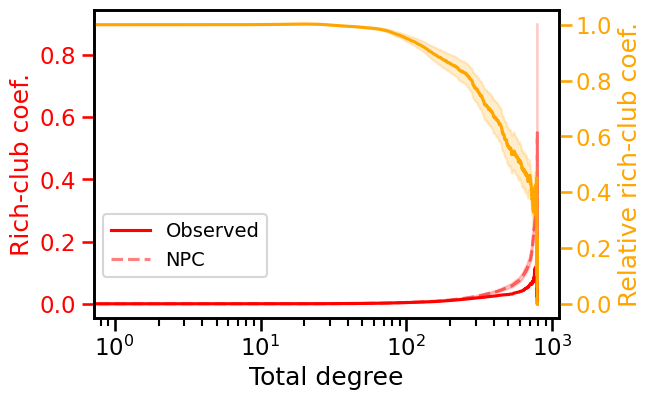

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(rich_club_coefficients["total"], color='red', label="Observed")
ax.plot(np.mean(rich_club_coefficients["total-npc"], axis=0), linestyle="--", color='red', alpha=0.5, label="NPC")

# Calculate mean and standard deviation
mean = np.mean(rich_club_coefficients["total-npc"], axis=0)
std = np.std(rich_club_coefficients["total-npc"], axis=0)

# Plot mean with shadow
ax.fill_between(range(len(mean)), mean - std, mean + std, color='red', alpha=0.2)

ax.set_xlabel("Total degree")
ax.set_xscale('log')
ax.tick_params(axis='y', colors='red')
ax.set_ylabel("Rich-club coef.", color='red')
plt.legend(loc="lower left", bbox_to_anchor=(0.0, 0.1), fontsize=14)

ax2 = ax.twinx()

# Calculate relative rich-club coefficients with standard deviation
relative_rc = np.divide(np.array(rich_club_coefficients["total"]), mean, out=np.zeros_like(mean), where=mean != 0)
relative_rc_std = np.std([np.divide(np.array(rich_club_coefficients["total"]), rich_club_coefficients["total-npc"][i], 
                      out=np.zeros_like(mean), where=mean != 0) for i in range(5)], axis=0)

ax2.plot(relative_rc, color='orange')
ax2.fill_between(range(len(relative_rc)), relative_rc - relative_rc_std, relative_rc + relative_rc_std, color='orange', alpha=0.2)

ax2.tick_params(axis='y', colors='orange')
ax2.set_ylabel("Relative rich-club coef.", color='orange')

# Add vertical dashed lines where relative_rc > 1
sig_range = np.arange(len(relative_rc))[relative_rc > 1.01]
if len(sig_range) > 0:
    ax.axvline(sig_range.min(), color='black', linestyle='--', linewidth=0.5)
    ax.axvline(sig_range.max(), color='black', linestyle='--', linewidth=0.5)
    # Fill the region between the vertical lines with transparent gray
    ax.fill_betweenx(ax.get_ylim(), sig_range.min(), sig_range.max(), facecolor='gray', alpha=0.2, edgecolor=None)

plt.savefig('figs/total-degree-npc-old-style.pdf', transparent=True)

## 2. In-degree rich-club

### 2.1 Observed Network

In [54]:
%%time
in_degrees = g.degree_property_map("in") 
degrees = sorted(np.unique(in_degrees.a))

# Create a list to store the rich club coefficients
rich_club_coefficients["in"] = []

# Compute the rich club coefficients for each value of k
for k in tqdm(degrees):
    subgraph = gt.GraphView(g, vfilt=(in_degrees.a >= k))
    m = subgraph.num_edges()
    nk = subgraph.num_vertices()
    if m > 0:
        k_edges = (nk * (nk - 1))
        rich_club_coefficients["in"].append(m / k_edges)
    else:
        rich_club_coefficients["in"].append(0)

  0%|          | 0/551 [00:00<?, ?it/s]

CPU times: user 7.85 s, sys: 274 ms, total: 8.12 s
Wall time: 8.1 s


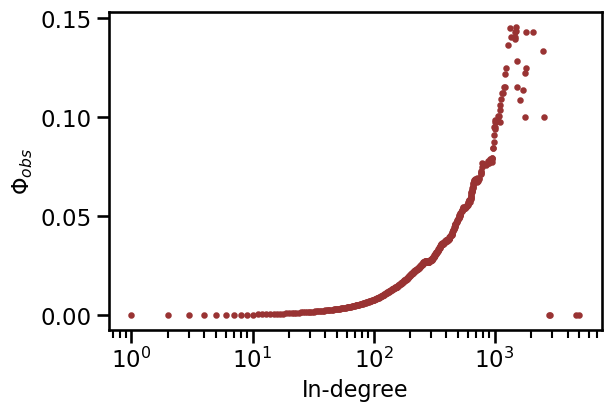

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
ax.scatter(degrees, rich_club_coefficients["in"], s=10, color=colors['obs'])
ax.set_xscale('log')
ax.set_xlabel('In-degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$', fontsize=16)
plt.savefig("figs/in-degree-phi-obs.pdf", transparent=True)

### 2.2 Configuration model (no self-loops, no parallel edges)

In [56]:
%%time
REPEAT = 10

rich_club_coefficients["in-cfg"] = []
g_rand = g.copy()

# Create a list to store the rich club coefficients
for rp in tqdm(range(REPEAT)):
    gt.random_rewire(g_rand, parallel_edges=False, self_loops=False)
    in_degrees = g_rand.degree_property_map("in") 
    degrees = sorted(np.unique(in_degrees.a))

    # Compute the rich club coefficients for each value of k
    for k in tqdm(degrees):
        subgraph = gt.GraphView(g_rand, vfilt=(in_degrees.a >= k))
        m = subgraph.num_edges()
        nk = subgraph.num_vertices()
        if m > 0:
            k_edges = (nk * (nk - 1))
            rich_club_coefficients["in-cfg"].append(m / k_edges)
        else:
            rich_club_coefficients["in-cfg"].append(0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

CPU times: user 1min 10s, sys: 5.56 s, total: 1min 15s
Wall time: 1min 15s


In [57]:
rich_club_coefficients["in-cfg"] = np.array(rich_club_coefficients["in-cfg"]).reshape(10, -1)

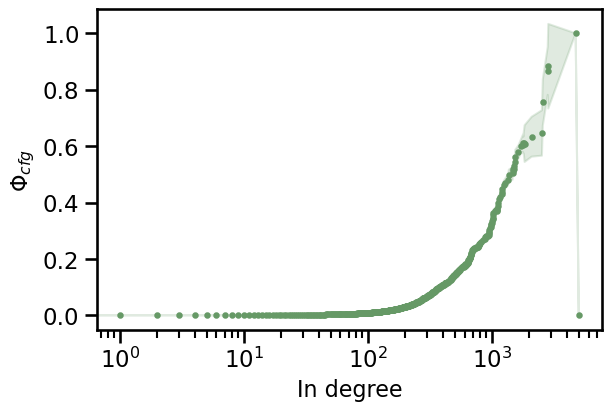

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["in-cfg"], axis=0)
stddevs = np.std(rich_club_coefficients["in-cfg"], axis=0)
ax.scatter(degrees, means, s=10, color=colors['cfg'])
ax.fill_between(degrees, means - stddevs, means + stddevs, color=colors['cfg'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('In degree', fontsize=16)
ax.set_ylabel('$\Phi_{cfg}$', fontsize=16)
plt.savefig("figs/in-degree-phi-cfg.pdf", transparent=True)

### 2.3 Neuropil Constrained Model

In [59]:
%%time
REPEAT = 10

rich_club_coefficients["in-npc"] = []
g_rand = g.copy()

# Create a list to store the rich club coefficients
for rp in tqdm(range(REPEAT)):
    gt.random_rewire(g_rand, model='blockmodel-degree', parallel_edges=False, self_loops=False, 
                     edge_probs = block_prob,
                     block_membership=g_rand.vp["neuropil_id"])
    in_degrees = g_rand.degree_property_map("in") 
    degrees = sorted(np.unique(in_degrees.a))

    # Compute the rich club coefficients for each value of k
    for k in tqdm(degrees):
        subgraph = gt.GraphView(g_rand, vfilt=(in_degrees.a >= k))
        m = subgraph.num_edges()
        nk = subgraph.num_vertices()
        if m > 0:
            k_edges = (nk * (nk - 1))
            rich_club_coefficients["in-npc"].append(m / k_edges)
        else:
            rich_club_coefficients["in-npc"].append(0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

CPU times: user 1min 2s, sys: 5.99 s, total: 1min 8s
Wall time: 1min 8s


In [64]:
rich_club_coefficients["in-npc"] = np.array(rich_club_coefficients["in-npc"]).reshape(REPEAT, -1)

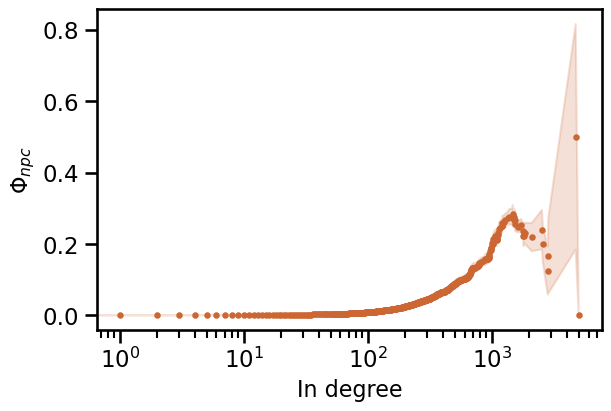

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["in-npc"], axis=0)
stddevs = np.std(rich_club_coefficients["in-npc"], axis=0)
ax.scatter(degrees, means, s=10, color=colors['npc'])
ax.fill_between(degrees, means - stddevs, means + stddevs, color=colors['npc'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('In degree', fontsize=16)
ax.set_ylabel('$\Phi_{npc}$', fontsize=16)
plt.savefig("figs/in-degree-phi-npc.pdf", transparent=True)

### 2.4 more plots for comparison

obs vs cfg

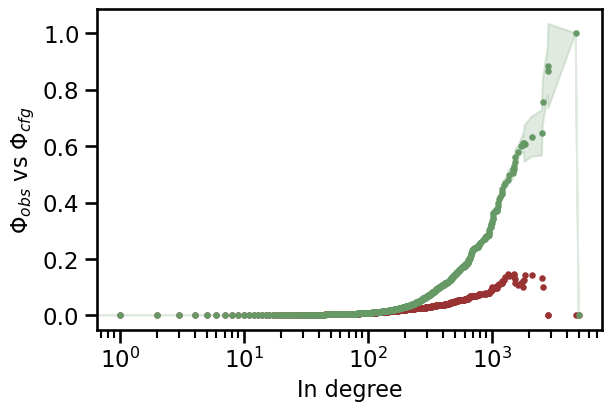

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["in-cfg"], axis=0)
stddevs = np.std(rich_club_coefficients["in-cfg"], axis=0)
ax.scatter(degrees, rich_club_coefficients["in"], s=10, color=colors['obs'])
ax.scatter(degrees, means, s=10, color=colors['cfg'])
ax.fill_between(degrees, means - stddevs, means + stddevs, color=colors['cfg'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('In degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ vs $\Phi_{cfg}$', fontsize=16)
plt.savefig("figs/in-degree-phi-obs-vs-cfg.pdf", transparent=True)

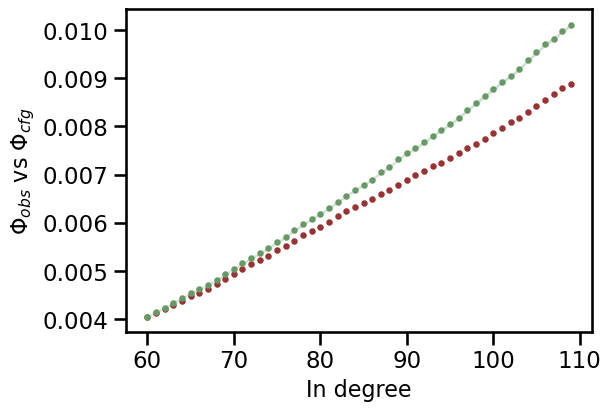

In [67]:
truncation = 110
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["in-cfg"], axis=0)[60:truncation]
stddevs = np.std(rich_club_coefficients["in-cfg"], axis=0)[60:truncation]
ax.scatter(degrees[60:truncation], rich_club_coefficients["in"][60:truncation], s=10, color=colors['obs'])
ax.scatter(degrees[60:truncation], means, s=10, color=colors['cfg'])
ax.fill_between(degrees[60:truncation], means - stddevs, means + stddevs, color=colors['cfg'], alpha=0.2)  # Shaded std dev
ax.set_xlabel('In degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ vs $\Phi_{cfg}$', fontsize=16)
plt.savefig("figs/in-degree-phi-obs-vs-cfg-truncated.pdf", transparent=True)

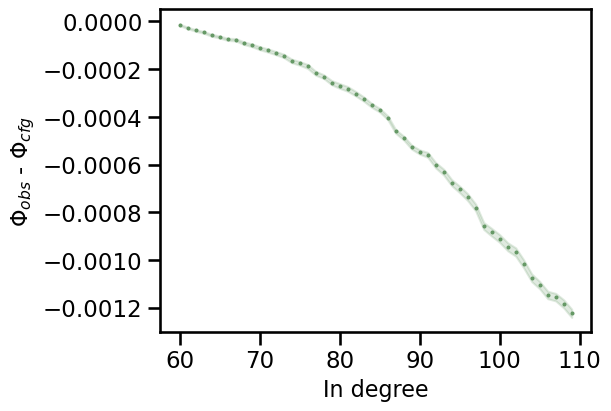

In [68]:
truncation = 110
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
diff = -(rich_club_coefficients["in-cfg"] - np.array(rich_club_coefficients["in"]))
means = np.mean(diff, axis=0)[60:truncation]
stddevs = np.std(diff, axis=0)[60:truncation]
ax.scatter(degrees[60:truncation], means, s=2, color=colors['cfg'])
ax.fill_between(degrees[60:truncation], means - stddevs, means + stddevs, color=colors['cfg'], alpha=0.2)  # Shaded std dev
ax.set_xlabel('In degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ - $\Phi_{cfg}$', fontsize=16)
plt.savefig("figs/in-degree-phi-obs-diff-cfg-truncated.pdf", transparent=True)

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/112701321.py:4: RuntimeWarning: invalid value encountered in divide
  rel_phi = obs_mean / means
/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/112701321.py:5: RuntimeWarning: invalid value encountered in divide
  stddevs = np.std(obs_mean / rich_club_coefficients["in-cfg"], axis=0)


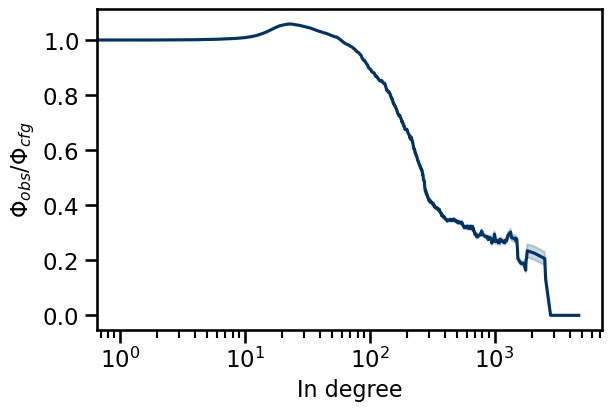

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
obs_mean = np.array(rich_club_coefficients["in"])
means = np.mean(rich_club_coefficients["in-cfg"], axis=0)
rel_phi = obs_mean / means
stddevs = np.std(obs_mean / rich_club_coefficients["in-cfg"], axis=0)
ax.plot(degrees, rel_phi, color=colors['rel-cfg'])
ax.fill_between(degrees, rel_phi - stddevs, rel_phi + stddevs, color=colors['rel-cfg'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('In degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs} / \Phi_{cfg}$', fontsize=16)
plt.savefig("figs/in-degree-phi-rel-cfg.pdf", transparent=True)

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/1934882338.py:5: RuntimeWarning: invalid value encountered in divide
  rel_phi = (obs_mean / means)[:truncation]
/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/1934882338.py:6: RuntimeWarning: invalid value encountered in divide
  stddevs = np.std(obs_mean / rich_club_coefficients["in-cfg"], axis=0)[:truncation]


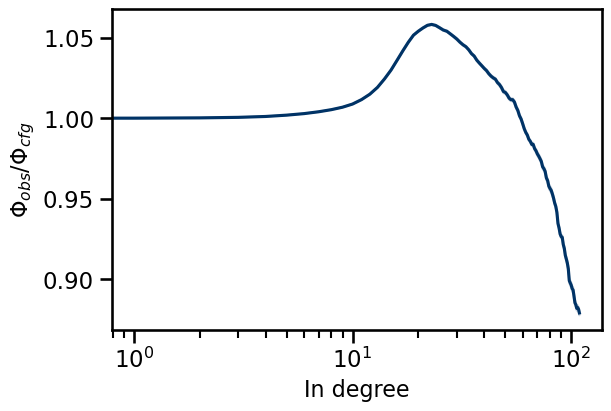

In [70]:
truncation = 110
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
obs_mean = np.array(rich_club_coefficients["in"])
means = np.mean(rich_club_coefficients["in-cfg"], axis=0)
rel_phi = (obs_mean / means)[:truncation]
stddevs = np.std(obs_mean / rich_club_coefficients["in-cfg"], axis=0)[:truncation]
ax.plot(degrees[:truncation], rel_phi, color=colors['rel-cfg'])
ax.fill_between(degrees[:truncation], rel_phi - stddevs, rel_phi + stddevs, color=colors['rel-cfg'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('In degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs} / \Phi_{cfg}$', fontsize=16)
plt.savefig("figs/in-degree-phi-rel-cfg-truncated.pdf", transparent=True)

obs vs npc

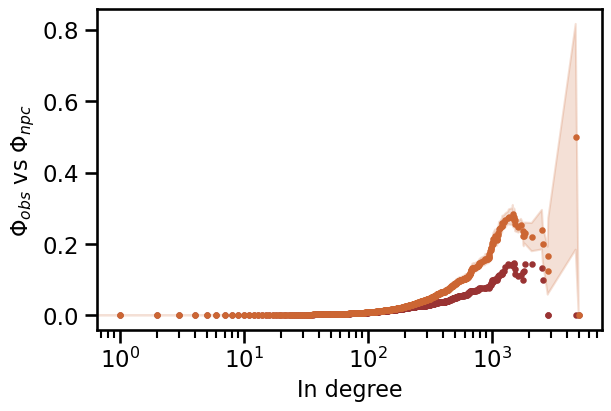

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["in-npc"], axis=0)
stddevs = np.std(rich_club_coefficients["in-npc"], axis=0)
ax.scatter(degrees, rich_club_coefficients["in"], s=10, color=colors['obs'])
ax.scatter(degrees, means, s=10, color=colors['npc'])
ax.fill_between(degrees, means - stddevs, means + stddevs, color=colors['npc'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('In degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ vs $\Phi_{npc}$', fontsize=16)
plt.savefig("figs/in-degree-phi-obs-vs-npc.pdf", transparent=True)

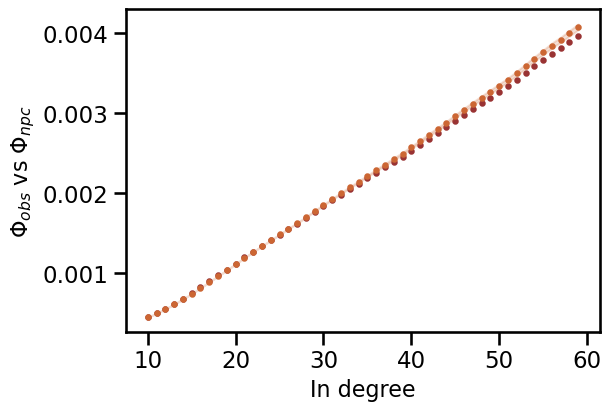

In [72]:
truncation = 60
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["in-npc"], axis=0)[10:truncation]
stddevs = np.std(rich_club_coefficients["in-npc"], axis=0)[10:truncation]
ax.scatter(degrees[10:truncation], rich_club_coefficients["in"][10:truncation], s=10, color=colors['obs'])
ax.scatter(degrees[10:truncation], means, s=10, color=colors['npc'])
ax.fill_between(degrees[10:truncation], means - stddevs, means + stddevs, color=colors['npc'], alpha=0.2)  # Shaded std dev
ax.set_xlabel('In degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ vs $\Phi_{npc}$', fontsize=16)
plt.savefig("figs/in-degree-phi-obs-vs-npc-truncated.pdf", transparent=True)

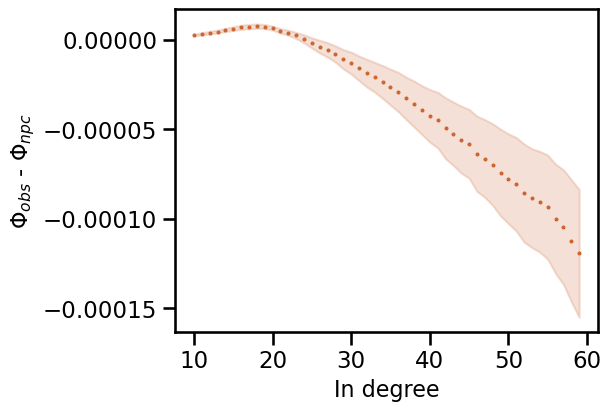

In [73]:
truncation = 60
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
diff = -(rich_club_coefficients["in-npc"] - np.array(rich_club_coefficients["in"]))
means = np.mean(diff, axis=0)[10:truncation]
stddevs = np.std(diff, axis=0)[10:truncation]
ax.scatter(degrees[10:truncation], means, s=2, color=colors['npc'])
ax.fill_between(degrees[10:truncation], means - stddevs, means + stddevs, color=colors['npc'], alpha=0.2)  # Shaded std dev
ax.set_xlabel('In degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ - $\Phi_{npc}$', fontsize=16)
plt.savefig("figs/in-degree-phi-obs-diff-npc-truncated.pdf", transparent=True)

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/3929492103.py:4: RuntimeWarning: invalid value encountered in divide
  rel_phi = obs_mean / means
/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/3929492103.py:5: RuntimeWarning: invalid value encountered in divide
  stddevs = np.std(obs_mean / rich_club_coefficients["in-npc"], axis=0)


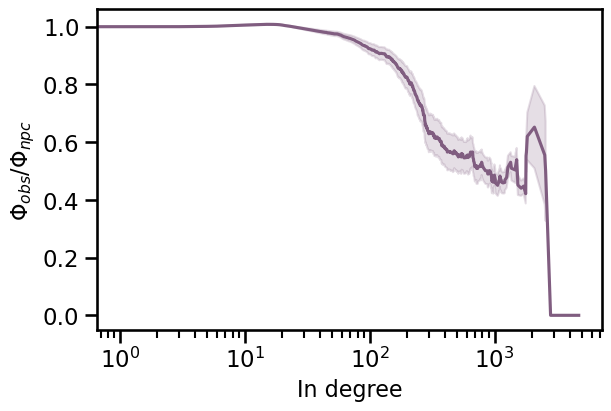

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
obs_mean = np.array(rich_club_coefficients["in"])
means = np.mean(rich_club_coefficients["in-npc"], axis=0)
rel_phi = obs_mean / means
stddevs = np.std(obs_mean / rich_club_coefficients["in-npc"], axis=0)
ax.plot(degrees, rel_phi, color=colors['rel-npc'])
ax.fill_between(degrees, rel_phi - stddevs, rel_phi + stddevs, color=colors['rel-npc'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('In degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs} / \Phi_{npc}$', fontsize=16)
plt.savefig("figs/in-degree-phi-rel-npc.pdf", transparent=True)

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/184796003.py:5: RuntimeWarning: invalid value encountered in divide
  rel_phi = (obs_mean / means)[:truncation]
/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/184796003.py:6: RuntimeWarning: invalid value encountered in divide
  stddevs = np.std(obs_mean / rich_club_coefficients["in-npc"], axis=0)[:truncation]


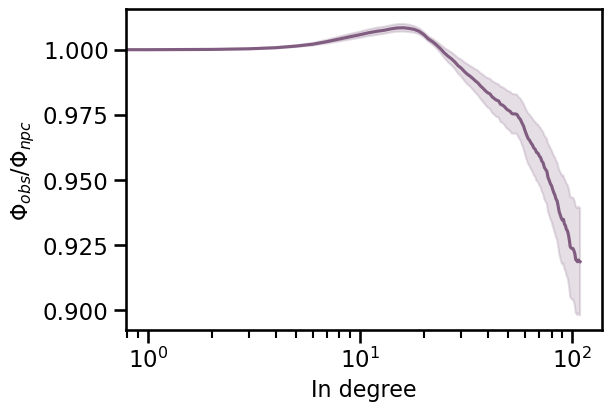

In [75]:
truncation = 110
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
obs_mean = np.array(rich_club_coefficients["in"])
means = np.mean(rich_club_coefficients["in-npc"], axis=0)
rel_phi = (obs_mean / means)[:truncation]
stddevs = np.std(obs_mean / rich_club_coefficients["in-npc"], axis=0)[:truncation]
ax.plot(degrees[:truncation], rel_phi, color=colors['rel-npc'])
ax.fill_between(degrees[:truncation], rel_phi - stddevs, rel_phi + stddevs, color=colors['rel-npc'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('In degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs} / \Phi_{npc}$', fontsize=16)
plt.savefig("figs/in-degree-phi-rel-npc-truncated.pdf", transparent=True)

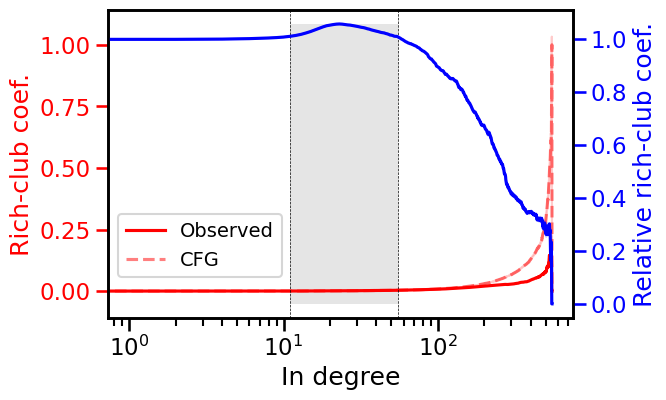

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(rich_club_coefficients["in"], color='red', label="Observed")
ax.plot(np.mean(rich_club_coefficients["in-cfg"], axis=0), linestyle="--", color='red', alpha=0.5, label="CFG")

# Calculate mean and standard deviation
mean = np.mean(rich_club_coefficients["in-cfg"], axis=0)
std = np.std(rich_club_coefficients["in-cfg"], axis=0)

# Plot mean with shadow
ax.fill_between(range(len(mean)), mean - std, mean + std, color='red', alpha=0.2)

ax.set_xlabel("In degree")
ax.set_xscale('log')
ax.tick_params(axis='y', colors='red')
ax.set_ylabel("Rich-club coef.", color='red')
plt.legend(loc="lower left", bbox_to_anchor=(0.0, 0.1), fontsize=14)

ax2 = ax.twinx()

# Calculate relative rich-club coefficients with standard deviation
relative_rc = np.divide(np.array(rich_club_coefficients["in"]), mean, out=np.zeros_like(mean), where=mean != 0)
relative_rc_std = np.std([np.divide(np.array(rich_club_coefficients["in"]), rich_club_coefficients["in-cfg"][i], 
                      out=np.zeros_like(mean), where=mean != 0) for i in range(5)], axis=0)

ax2.plot(relative_rc, color='blue')
ax2.fill_between(range(len(relative_rc)), relative_rc - relative_rc_std, relative_rc + relative_rc_std, color='blue', alpha=0.2)

ax2.tick_params(axis='y', colors='blue')
ax2.set_ylabel("Relative rich-club coef.", color='blue')

# Add vertical dashed lines where relative_rc > 1
sig_range = np.arange(len(relative_rc))[relative_rc > 1.01]
ax.axvline(sig_range.min(), color='black', linestyle='--', linewidth=0.5)
ax.axvline(sig_range.max(), color='black', linestyle='--', linewidth=0.5)

# Fill the region between the vertical lines with transparent gray
ax.fill_betweenx(ax.get_ylim(), sig_range.min(), sig_range.max(), facecolor='gray', alpha=0.2, edgecolor=None)

plt.savefig('figs/in-degree-cfg-old-style.pdf', transparent=True)

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/2203194767.py:22: RuntimeWarning: invalid value encountered in divide
  relative_rc_std = np.std([np.divide(np.array(rich_club_coefficients["in"]), rich_club_coefficients["in-npc"][i],


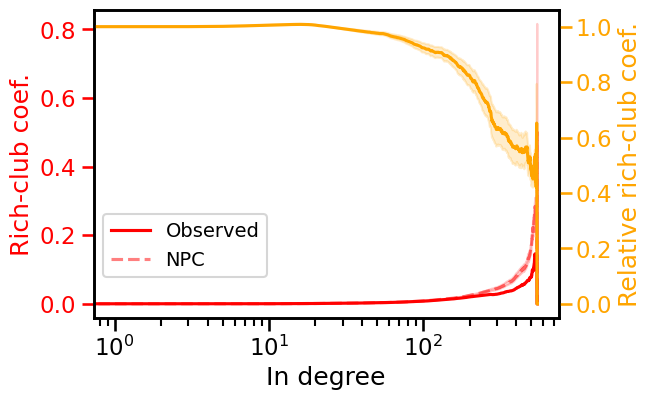

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(rich_club_coefficients["in"], color='red', label="Observed")
ax.plot(np.mean(rich_club_coefficients["in-npc"], axis=0), linestyle="--", color='red', alpha=0.5, label="NPC")

# Calculate mean and standard deviation
mean = np.mean(rich_club_coefficients["in-npc"], axis=0)
std = np.std(rich_club_coefficients["in-npc"], axis=0)

# Plot mean with shadow
ax.fill_between(range(len(mean)), mean - std, mean + std, color='red', alpha=0.2)

ax.set_xlabel("In degree")
ax.set_xscale('log')
ax.tick_params(axis='y', colors='red')
ax.set_ylabel("Rich-club coef.", color='red')
plt.legend(loc="lower left", bbox_to_anchor=(0.0, 0.1), fontsize=14)

ax2 = ax.twinx()

# Calculate relative rich-club coefficients with standard deviation
relative_rc = np.divide(np.array(rich_club_coefficients["in"]), mean, out=np.zeros_like(mean), where=mean != 0)
relative_rc_std = np.std([np.divide(np.array(rich_club_coefficients["in"]), rich_club_coefficients["in-npc"][i], 
                      out=np.zeros_like(mean), where=mean != 0) for i in range(5)], axis=0)

ax2.plot(relative_rc, color='orange')
ax2.fill_between(range(len(relative_rc)), relative_rc - relative_rc_std, relative_rc + relative_rc_std, color='orange', alpha=0.2)

ax2.tick_params(axis='y', colors='orange')
ax2.set_ylabel("Relative rich-club coef.", color='orange')

# Add vertical dashed lines where relative_rc > 1
sig_range = np.arange(len(relative_rc))[relative_rc > 1.01]
if len(sig_range) > 0:
    ax.axvline(sig_range.min(), color='black', linestyle='--', linewidth=0.5)
    ax.axvline(sig_range.max(), color='black', linestyle='--', linewidth=0.5)
    # Fill the region between the vertical lines with transparent gray
    ax.fill_betweenx(ax.get_ylim(), sig_range.min(), sig_range.max(), facecolor='gray', alpha=0.2, edgecolor=None)

plt.savefig('figs/in-degree-npc-old-style.pdf', transparent=True)

## 3. Out-degree rich-club

### 3.1 Observed Network

In [82]:
%%time
out_degrees = g.degree_property_map("out") 
degrees = sorted(np.unique(out_degrees.a))

# Create a list to store the rich club coefficients
rich_club_coefficients["out"] = []

# Compute the rich club coefficients for each value of k
for k in tqdm(degrees):
    subgraph = gt.GraphView(g, vfilt=(out_degrees.a >= k))
    m = subgraph.num_edges()
    nk = subgraph.num_vertices()
    if m > 0:
        k_edges = (nk * (nk - 1))
        rich_club_coefficients["out"].append(m / k_edges)
    else:
        rich_club_coefficients["out"].append(0)

  0%|          | 0/509 [00:00<?, ?it/s]

CPU times: user 7.27 s, sys: 242 ms, total: 7.52 s
Wall time: 7.5 s


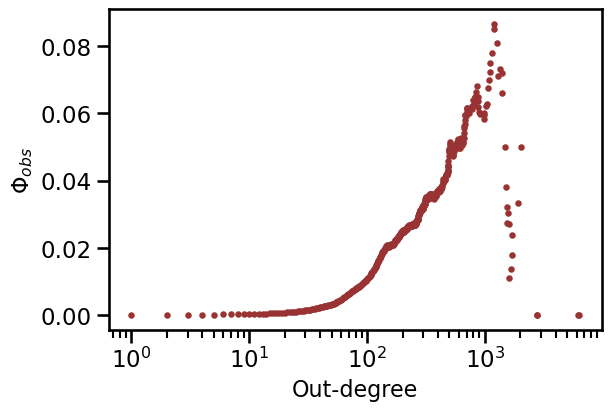

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
ax.scatter(degrees, rich_club_coefficients["out"], s=10, color=colors['obs'])
ax.set_xscale('log')
ax.set_xlabel('Out-degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$', fontsize=16)
plt.savefig("figs/out-degree-phi-obs.pdf", transparent=True)

### 3.2 Configuration model (no self-loops, no parallel edges)

In [85]:
%%time
REPEAT = 10

rich_club_coefficients["out-cfg"] = []
g_rand = g.copy()

# Create a list to store the rich club coefficients
for rp in tqdm(range(REPEAT)):
    gt.random_rewire(g_rand, parallel_edges=False, self_loops=False)
    out_degrees = g_rand.degree_property_map("out") 
    degrees = sorted(np.unique(out_degrees.a))

    # Compute the rich club coefficients for each value of k
    for k in tqdm(degrees):
        subgraph = gt.GraphView(g_rand, vfilt=(out_degrees.a >= k))
        m = subgraph.num_edges()
        nk = subgraph.num_vertices()
        if m > 0:
            k_edges = (nk * (nk - 1))
            rich_club_coefficients["out-cfg"].append(m / k_edges)
        else:
            rich_club_coefficients["out-cfg"].append(0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

CPU times: user 1min 4s, sys: 5.33 s, total: 1min 9s
Wall time: 1min 9s


In [88]:
rich_club_coefficients["out-cfg"] = np.array(rich_club_coefficients["out-cfg"]).reshape(10, -1)

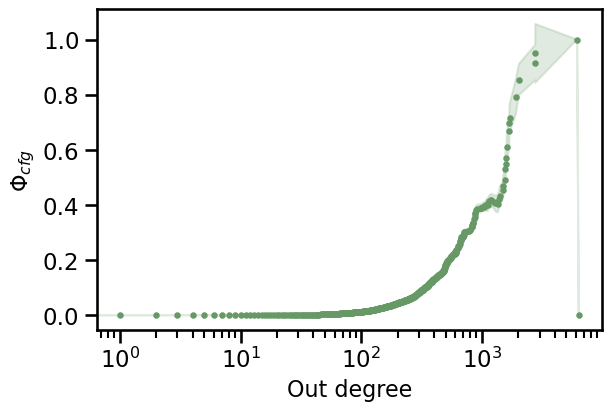

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["out-cfg"], axis=0)
stddevs = np.std(rich_club_coefficients["out-cfg"], axis=0)
ax.scatter(degrees, means, s=10, color=colors['cfg'])
ax.fill_between(degrees, means - stddevs, means + stddevs, color=colors['cfg'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('Out degree', fontsize=16)
ax.set_ylabel('$\Phi_{cfg}$', fontsize=16)
plt.savefig("figs/out-degree-phi-cfg.pdf", transparent=True)

### 3.3 Neuropil Constrained Model

In [90]:
%%time
REPEAT = 10

rich_club_coefficients["out-npc"] = []
g_rand = g.copy()

# Create a list to store the rich club coefficients
for rp in tqdm(range(REPEAT)):
    gt.random_rewire(g_rand, model='blockmodel-degree', parallel_edges=False, self_loops=False, 
                     edge_probs = block_prob,
                     block_membership=g_rand.vp["neuropil_id"])
    out_degrees = g_rand.degree_property_map("out") 
    degrees = sorted(np.unique(out_degrees.a))

    # Compute the rich club coefficients for each value of k
    for k in tqdm(degrees):
        subgraph = gt.GraphView(g_rand, vfilt=(out_degrees.a >= k))
        m = subgraph.num_edges()
        nk = subgraph.num_vertices()
        if m > 0:
            k_edges = (nk * (nk - 1))
            rich_club_coefficients["out-npc"].append(m / k_edges)
        else:
            rich_club_coefficients["out-npc"].append(0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

CPU times: user 60 s, sys: 5.26 s, total: 1min 5s
Wall time: 1min 5s


In [91]:
rich_club_coefficients["out-npc"] = np.array(rich_club_coefficients["out-npc"]).reshape(REPEAT, -1)

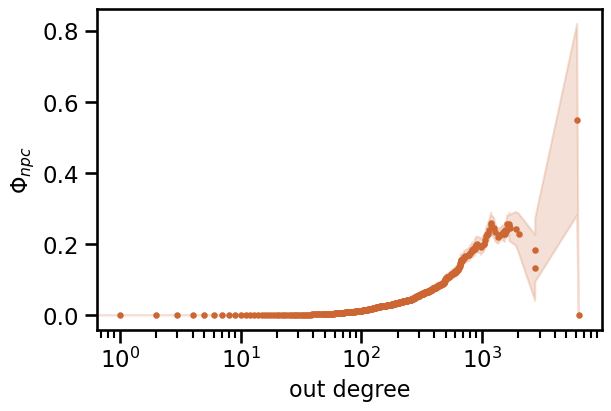

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["out-npc"], axis=0)
stddevs = np.std(rich_club_coefficients["out-npc"], axis=0)
ax.scatter(degrees, means, s=10, color=colors['npc'])
ax.fill_between(degrees, means - stddevs, means + stddevs, color=colors['npc'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('out degree', fontsize=16)
ax.set_ylabel('$\Phi_{npc}$', fontsize=16)
plt.savefig("figs/out-degree-phi-npc.pdf", transparent=True)

### 3.4 more plots for comparison

obs vs cfg

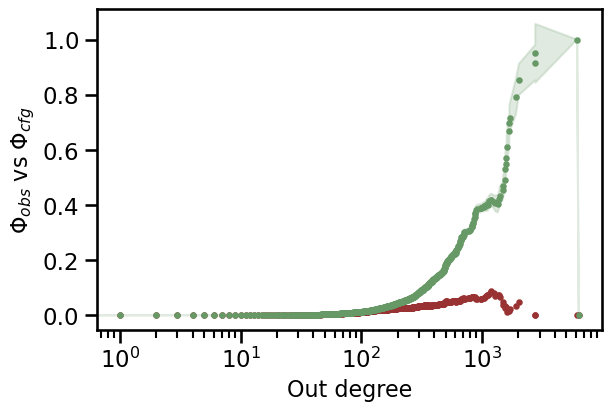

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["out-cfg"], axis=0)
stddevs = np.std(rich_club_coefficients["out-cfg"], axis=0)
ax.scatter(degrees, rich_club_coefficients["out"], s=10, color=colors['obs'])
ax.scatter(degrees, means, s=10, color=colors['cfg'])
ax.fill_between(degrees, means - stddevs, means + stddevs, color=colors['cfg'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('Out degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ vs $\Phi_{cfg}$', fontsize=16)
plt.savefig("figs/out-degree-phi-obs-vs-cfg.pdf", transparent=True)

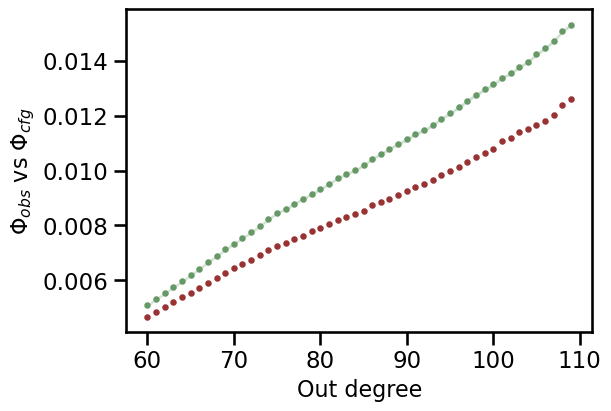

In [94]:
truncation = 110
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["out-cfg"], axis=0)[60:truncation]
stddevs = np.std(rich_club_coefficients["out-cfg"], axis=0)[60:truncation]
ax.scatter(degrees[60:truncation], rich_club_coefficients["out"][60:truncation], s=10, color=colors['obs'])
ax.scatter(degrees[60:truncation], means, s=10, color=colors['cfg'])
ax.fill_between(degrees[60:truncation], means - stddevs, means + stddevs, color=colors['cfg'], alpha=0.2)  # Shaded std dev
ax.set_xlabel('Out degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ vs $\Phi_{cfg}$', fontsize=16)
plt.savefig("figs/out-degree-phi-obs-vs-cfg-truncated.pdf", transparent=True)

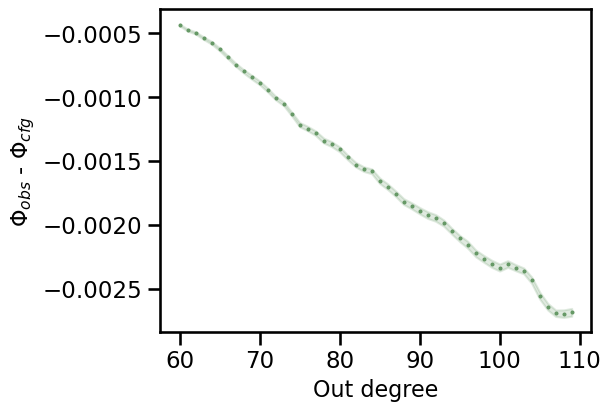

In [95]:
truncation = 110
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
diff = -(rich_club_coefficients["out-cfg"] - np.array(rich_club_coefficients["out"]))
means = np.mean(diff, axis=0)[60:truncation]
stddevs = np.std(diff, axis=0)[60:truncation]
ax.scatter(degrees[60:truncation], means, s=2, color=colors['cfg'])
ax.fill_between(degrees[60:truncation], means - stddevs, means + stddevs, color=colors['cfg'], alpha=0.2)  # Shaded std dev
ax.set_xlabel('Out degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ - $\Phi_{cfg}$', fontsize=16)
plt.savefig("figs/out-degree-phi-obs-diff-cfg-truncated.pdf", transparent=True)

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/2809667062.py:4: RuntimeWarning: invalid value encountered in divide
  rel_phi = obs_mean / means
/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/2809667062.py:5: RuntimeWarning: invalid value encountered in divide
  stddevs = np.std(obs_mean / rich_club_coefficients["out-cfg"], axis=0)


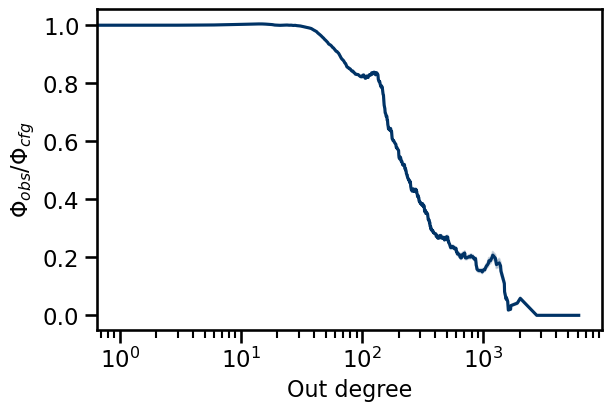

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
obs_mean = np.array(rich_club_coefficients["out"])
means = np.mean(rich_club_coefficients["out-cfg"], axis=0)
rel_phi = obs_mean / means
stddevs = np.std(obs_mean / rich_club_coefficients["out-cfg"], axis=0)
ax.plot(degrees, rel_phi, color=colors['rel-cfg'])
ax.fill_between(degrees, rel_phi - stddevs, rel_phi + stddevs, color=colors['rel-cfg'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('Out degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs} / \Phi_{cfg}$', fontsize=16)
plt.savefig("figs/out-degree-phi-rel-cfg.pdf", transparent=True)

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/2873634029.py:5: RuntimeWarning: invalid value encountered in divide
  rel_phi = (obs_mean / means)[:truncation]
/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/2873634029.py:6: RuntimeWarning: invalid value encountered in divide
  stddevs = np.std(obs_mean / rich_club_coefficients["out-cfg"], axis=0)[:truncation]


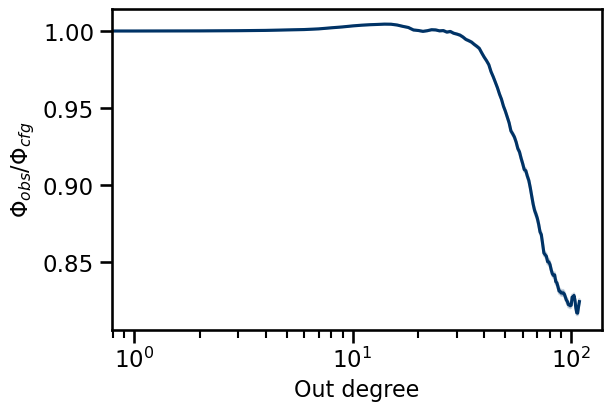

In [97]:
truncation = 110
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
obs_mean = np.array(rich_club_coefficients["out"])
means = np.mean(rich_club_coefficients["out-cfg"], axis=0)
rel_phi = (obs_mean / means)[:truncation]
stddevs = np.std(obs_mean / rich_club_coefficients["out-cfg"], axis=0)[:truncation]
ax.plot(degrees[:truncation], rel_phi, color=colors['rel-cfg'])
ax.fill_between(degrees[:truncation], rel_phi - stddevs, rel_phi + stddevs, color=colors['rel-cfg'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('Out degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs} / \Phi_{cfg}$', fontsize=16)
plt.savefig("figs/out-degree-phi-rel-cfg-truncated.pdf", transparent=True)

obs vs npc

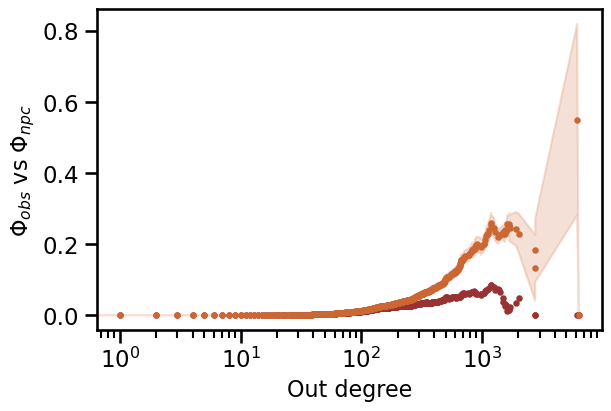

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["out-npc"], axis=0)
stddevs = np.std(rich_club_coefficients["out-npc"], axis=0)
ax.scatter(degrees, rich_club_coefficients["out"], s=10, color=colors['obs'])
ax.scatter(degrees, means, s=10, color=colors['npc'])
ax.fill_between(degrees, means - stddevs, means + stddevs, color=colors['npc'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('Out degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ vs $\Phi_{npc}$', fontsize=16)
plt.savefig("figs/out-degree-phi-obs-vs-npc.pdf", transparent=True)

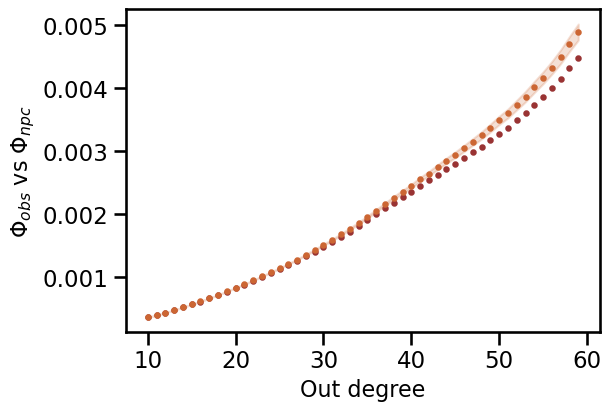

In [99]:
truncation = 60
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["out-npc"], axis=0)[10:truncation]
stddevs = np.std(rich_club_coefficients["out-npc"], axis=0)[10:truncation]
ax.scatter(degrees[10:truncation], rich_club_coefficients["out"][10:truncation], s=10, color=colors['obs'])
ax.scatter(degrees[10:truncation], means, s=10, color=colors['npc'])
ax.fill_between(degrees[10:truncation], means - stddevs, means + stddevs, color=colors['npc'], alpha=0.2)  # Shaded std dev
ax.set_xlabel('Out degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ vs $\Phi_{npc}$', fontsize=16)
plt.savefig("figs/out-degree-phi-obs-vs-npc-truncated.pdf", transparent=True)

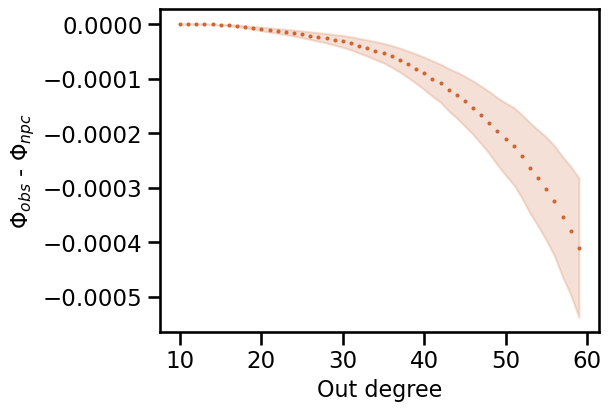

In [100]:
truncation = 60
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
diff = -(rich_club_coefficients["out-npc"] - np.array(rich_club_coefficients["out"]))
means = np.mean(diff, axis=0)[10:truncation]
stddevs = np.std(diff, axis=0)[10:truncation]
ax.scatter(degrees[10:truncation], means, s=2, color=colors['npc'])
ax.fill_between(degrees[10:truncation], means - stddevs, means + stddevs, color=colors['npc'], alpha=0.2)  # Shaded std dev
ax.set_xlabel('Out degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ - $\Phi_{npc}$', fontsize=16)
plt.savefig("figs/out-degree-phi-obs-diff-npc-truncated.pdf", transparent=True)

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/1537109428.py:4: RuntimeWarning: invalid value encountered in divide
  rel_phi = obs_mean / means
/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/1537109428.py:5: RuntimeWarning: invalid value encountered in divide
  stddevs = np.std(obs_mean / rich_club_coefficients["out-npc"], axis=0)


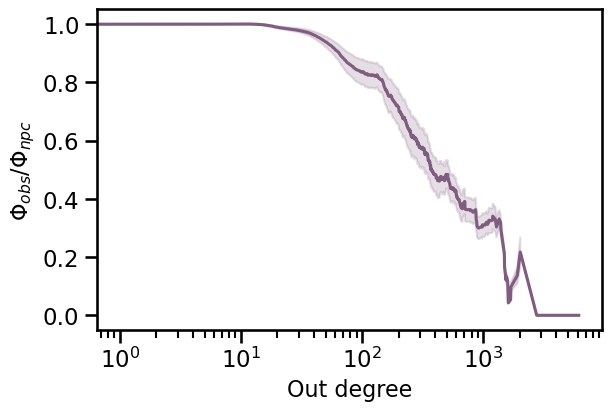

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
obs_mean = np.array(rich_club_coefficients["out"])
means = np.mean(rich_club_coefficients["out-npc"], axis=0)
rel_phi = obs_mean / means
stddevs = np.std(obs_mean / rich_club_coefficients["out-npc"], axis=0)
ax.plot(degrees, rel_phi, color=colors['rel-npc'])
ax.fill_between(degrees, rel_phi - stddevs, rel_phi + stddevs, color=colors['rel-npc'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('Out degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs} / \Phi_{npc}$', fontsize=16)
plt.savefig("figs/out-degree-phi-rel-npc.pdf", transparent=True)

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/1392127653.py:5: RuntimeWarning: invalid value encountered in divide
  rel_phi = (obs_mean / means)[:truncation]
/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/1392127653.py:6: RuntimeWarning: invalid value encountered in divide
  stddevs = np.std(obs_mean / rich_club_coefficients["out-npc"], axis=0)[:truncation]


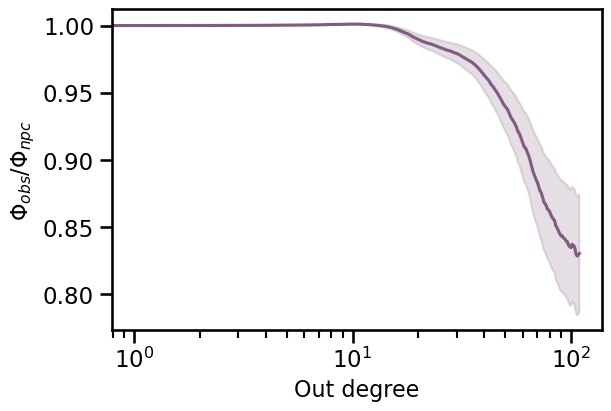

In [102]:
truncation = 110
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
obs_mean = np.array(rich_club_coefficients["out"])
means = np.mean(rich_club_coefficients["out-npc"], axis=0)
rel_phi = (obs_mean / means)[:truncation]
stddevs = np.std(obs_mean / rich_club_coefficients["out-npc"], axis=0)[:truncation]
ax.plot(degrees[:truncation], rel_phi, color=colors['rel-npc'])
ax.fill_between(degrees[:truncation], rel_phi - stddevs, rel_phi + stddevs, color=colors['rel-npc'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('Out degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs} / \Phi_{npc}$', fontsize=16)
plt.savefig("figs/out-degree-phi-rel-npc-truncated.pdf", transparent=True)

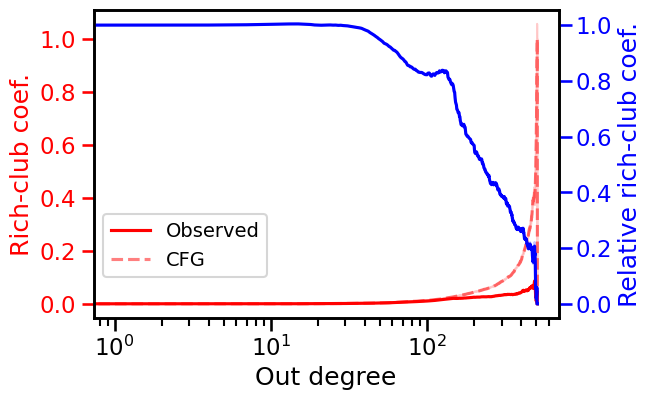

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(rich_club_coefficients["out"], color='red', label="Observed")
ax.plot(np.mean(rich_club_coefficients["out-cfg"], axis=0), linestyle="--", color='red', alpha=0.5, label="CFG")

# Calculate mean and standard deviation
mean = np.mean(rich_club_coefficients["out-cfg"], axis=0)
std = np.std(rich_club_coefficients["out-cfg"], axis=0)

# Plot mean with shadow
ax.fill_between(range(len(mean)), mean - std, mean + std, color='red', alpha=0.2)

ax.set_xlabel("Out degree")
ax.set_xscale('log')
ax.tick_params(axis='y', colors='red')
ax.set_ylabel("Rich-club coef.", color='red')
plt.legend(loc="lower left", bbox_to_anchor=(0.0, 0.1), fontsize=14)

ax2 = ax.twinx()

# Calculate relative rich-club coefficients with standard deviation
relative_rc = np.divide(np.array(rich_club_coefficients["out"]), mean, out=np.zeros_like(mean), where=mean != 0)
relative_rc_std = np.std([np.divide(np.array(rich_club_coefficients["out"]), rich_club_coefficients["out-cfg"][i], 
                      out=np.zeros_like(mean), where=mean != 0) for i in range(5)], axis=0)

ax2.plot(relative_rc, color='blue')
ax2.fill_between(range(len(relative_rc)), relative_rc - relative_rc_std, relative_rc + relative_rc_std, color='blue', alpha=0.2)

ax2.tick_params(axis='y', colors='blue')
ax2.set_ylabel("Relative rich-club coef.", color='blue')

# Add vertical dashed lines where relative_rc > 1
sig_range = np.arange(len(relative_rc))[relative_rc > 1.01]
if len(sig_range) > 0:
    ax.axvline(sig_range.min(), color='black', linestyle='--', linewidth=0.5)
    ax.axvline(sig_range.max(), color='black', linestyle='--', linewidth=0.5)
    # Fill the region between the vertical lines with transparent gray
    ax.fill_betweenx(ax.get_ylim(), sig_range.min(), sig_range.max(), facecolor='gray', alpha=0.2, edgecolor=None)


plt.savefig('figs/out-degree-cfg-old-style.pdf', transparent=True)

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/2253841822.py:22: RuntimeWarning: invalid value encountered in divide
  relative_rc_std = np.std([np.divide(np.array(rich_club_coefficients["out"]), rich_club_coefficients["out-npc"][i],


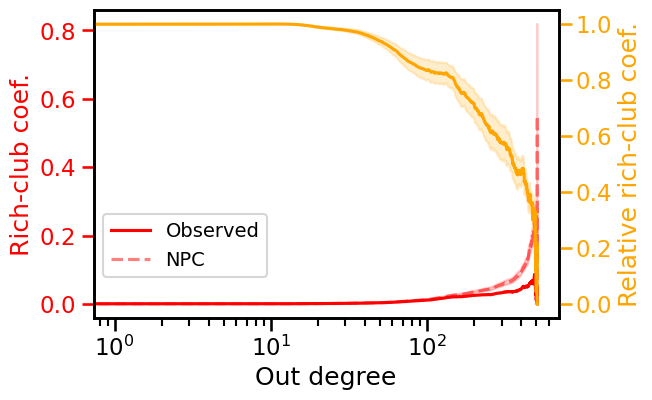

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(rich_club_coefficients["out"], color='red', label="Observed")
ax.plot(np.mean(rich_club_coefficients["out-npc"], axis=0), linestyle="--", color='red', alpha=0.5, label="NPC")

# Calculate mean and standard deviation
mean = np.mean(rich_club_coefficients["out-npc"], axis=0)
std = np.std(rich_club_coefficients["out-npc"], axis=0)

# Plot mean with shadow
ax.fill_between(range(len(mean)), mean - std, mean + std, color='red', alpha=0.2)

ax.set_xlabel("Out degree")
ax.set_xscale('log')
ax.tick_params(axis='y', colors='red')
ax.set_ylabel("Rich-club coef.", color='red')
plt.legend(loc="lower left", bbox_to_anchor=(0.0, 0.1), fontsize=14)

ax2 = ax.twinx()

# Calculate relative rich-club coefficients with standard deviation
relative_rc = np.divide(np.array(rich_club_coefficients["out"]), mean, out=np.zeros_like(mean), where=mean != 0)
relative_rc_std = np.std([np.divide(np.array(rich_club_coefficients["out"]), rich_club_coefficients["out-npc"][i], 
                      out=np.zeros_like(mean), where=mean != 0) for i in range(5)], axis=0)

ax2.plot(relative_rc, color='orange')
ax2.fill_between(range(len(relative_rc)), relative_rc - relative_rc_std, relative_rc + relative_rc_std, color='orange', alpha=0.2)

ax2.tick_params(axis='y', colors='orange')
ax2.set_ylabel("Relative rich-club coef.", color='orange')

# Add vertical dashed lines where relative_rc > 1
sig_range = np.arange(len(relative_rc))[relative_rc > 1.01]
if len(sig_range) > 0:
    ax.axvline(sig_range.min(), color='black', linestyle='--', linewidth=0.5)
    ax.axvline(sig_range.max(), color='black', linestyle='--', linewidth=0.5)
    # Fill the region between the vertical lines with transparent gray
    ax.fill_betweenx(ax.get_ylim(), sig_range.min(), sig_range.max(), facecolor='gray', alpha=0.2, edgecolor=None)

plt.savefig('figs/out-degree-npc-old-style.pdf', transparent=True)

## 4. Degree Distribution

In [127]:
all_degrees = g.get_total_degrees(g.get_vertices())

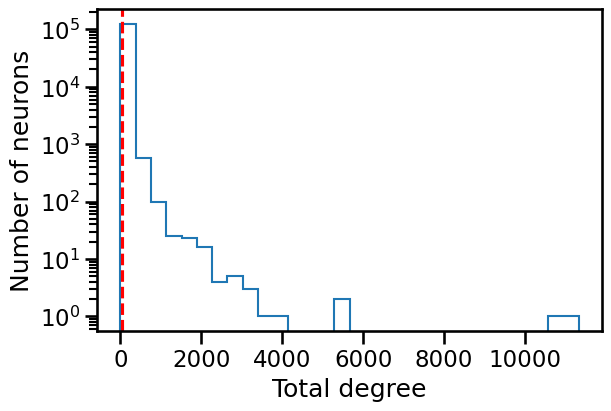

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
ax.hist(all_degrees, bins=30, histtype='step', log=True)
ax.axvline(x=37, color='red', linestyle='--', label='x=37')
ax.set_xlabel('Total degree')
ax.set_ylabel('Number of neurons')
plt.savefig('figs/degree-dist-normal-scale.pdf', transparent=True)

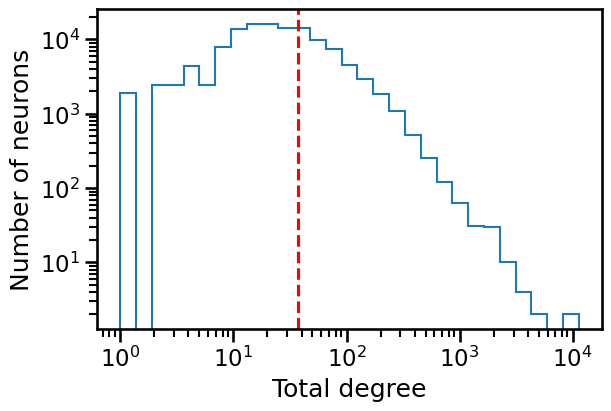

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
ax.hist(all_degrees, bins=np.logspace(np.log10(min(all_degrees)), np.log10(max(all_degrees)), 30), histtype='step', log=True)
ax.set_xscale('log')
ax.axvline(x=37, color='red', linestyle='--', label='x=37')
ax.set_xlabel('Total degree')
ax.set_ylabel('Number of neurons')
plt.savefig('figs/degree-dist-log-scale.pdf', transparent=True)

## 5. Neurotransmitter percentage vs Degree

In [107]:
def weighted_majority_nt(group):
    # Calculating weighted counts
    weighted_counts = group.groupby('nt_type')['syn_count'].sum()
    # Returning the neuropil with the highest weighted count
    return weighted_counts.idxmax()

cell_nt_assignment = syn_table.groupby('pre_root_id').apply(weighted_majority_nt).reset_index(name='majority_neurotransmitter')

In [108]:
nts = list(np.unique(cell_nt_assignment['majority_neurotransmitter']))
nt2ntid = {name: i for i, name in enumerate(nts)}

In [109]:
nt2ntid

{'ACH': 0, 'DA': 1, 'GABA': 2, 'GLUT': 3, 'OCT': 4, 'SER': 5}

In [110]:
ntid2nt = {nt2ntid[k]: k for k in nt2ntid.keys()}

In [111]:
ntid2nt

{0: 'ACH', 1: 'DA', 2: 'GABA', 3: 'GLUT', 4: 'OCT', 5: 'SER'}

In [112]:
nt_colors = {0: "#95A3CE", 1: "#B87969", 2: "#D5A848", 3: "#86A859", 4: "#725C98", 5: "#8C6295"}

In [113]:
cid2ntid = dict(zip(cell_nt_assignment['pre_root_id'], cell_nt_assignment['majority_neurotransmitter'].map(nt2ntid).values))

In [114]:
def get_ntid(v):
    if v in cid2ntid.keys():
        return cid2ntid[v]
    else:
        return -1

In [115]:
g.vp["nt_id"] = g.new_vp("int32_t")

In [116]:
g.vp["nt_id"].a = np.array([get_ntid(v) for v in np.array(g.vp['cellid'].a)])

In [117]:
%%time
total_degrees = g.degree_property_map("total") 
degrees = sorted(np.unique(total_degrees.a))

# Create a list to store the rich club coefficients
nt_perc = {i: [] for i in range(6)}

# Compute the rich club coefficients for each value of k
for k in tqdm(degrees):
    nt_types = g.vp['nt_id'].a[total_degrees.a >= k]
    for i in range(6):
        nt = float((nt_types == i).sum() / len(nt_types))
        nt_perc[i].append(nt)

  0%|          | 0/792 [00:00<?, ?it/s]

CPU times: user 112 ms, sys: 2.98 ms, total: 115 ms
Wall time: 113 ms


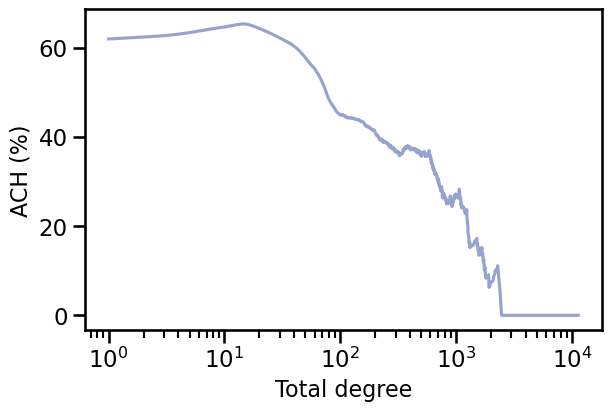

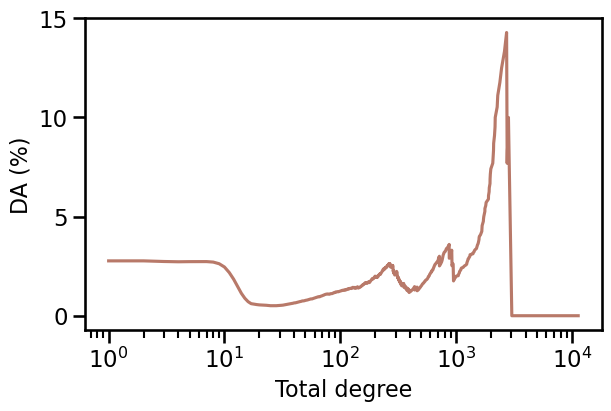

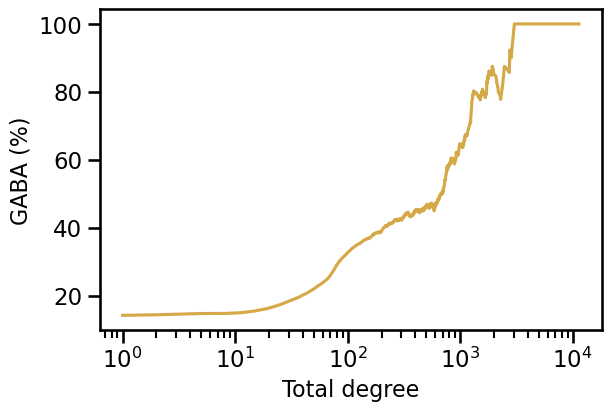

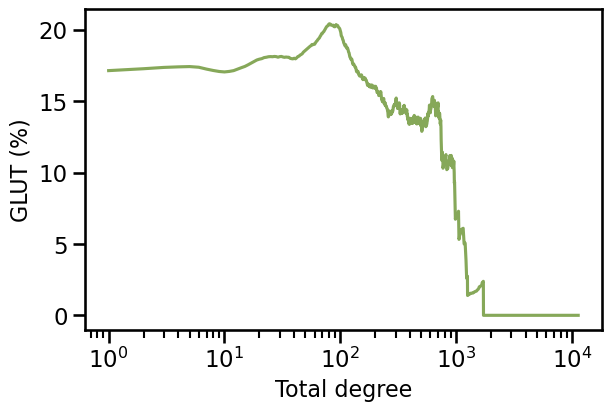

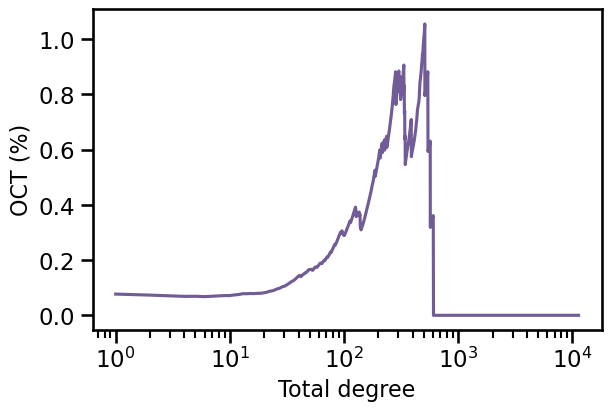

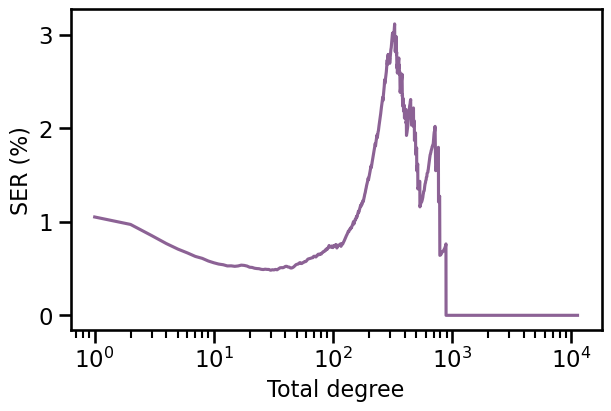

In [138]:
for nt_id in range(6):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
    ax.plot(degrees, np.array(nt_perc[nt_id]) * 100, color=nt_colors[nt_id])
    ax.set_xscale('log')
    ax.set_xlabel('Total degree', fontsize=16)
    ax.set_ylabel(f'{ntid2nt[nt_id]} (%)', fontsize=16)
    plt.savefig(f"figs/nt-degree-{ntid2nt[nt_id]}.pdf", transparent=True)

## 6. Other NPC stats: clustering coefficient, edge reciprocity

In [51]:
REPEAT = 100
g_rand = g.copy()
npc_reciprocity = []
for rp in tqdm(range(REPEAT)):
    gt.random_rewire(g_rand, model='blockmodel-degree', parallel_edges=False, self_loops=False, 
                     edge_probs = block_prob,
                     block_membership=g_rand.vp["neuropil_id"])
    npc_reciprocity.append(gt.edge_reciprocity(g_rand))

  0%|          | 0/100 [00:00<?, ?it/s]

In [55]:
np.mean(npc_reciprocity), np.std(npc_reciprocity), np.std(npc_reciprocity) / np.sqrt(REPEAT)

(0.01912273753037068, 0.005450724564887807, 0.0005450724564887808)

In [56]:
REPEAT = 100
g_rand = g.copy()
npc_clustering = []
for rp in tqdm(range(REPEAT)):
    gt.random_rewire(g_rand, model='blockmodel-degree', parallel_edges=False, self_loops=False, 
                     edge_probs = block_prob,
                     block_membership=g_rand.vp["neuropil_id"])
    npc_clustering.append(gt.global_clustering(g_rand, sampled=True, m=1000))

  0%|          | 0/100 [00:00<?, ?it/s]

In [57]:
np.mean(npc_clustering), np.std(npc_clustering), np.std(npc_clustering) / np.sqrt(REPEAT)

(0.01605, 0.004607331114647611, 0.0004607331114647611)

## 7. Extra models for total degree rich club: ER, SBM
They are less reasonable choices since the degree distribution is altered.

### 7.1 Neuropil Constrained Model, without degree correction

In [146]:
%%time
REPEAT = 10

rich_club_coefficients["total-sbm"] = []
g_rand = g.copy()

# Create a list to store the rich club coefficients
for rp in tqdm(range(REPEAT)):
    gt.random_rewire(g_rand, model='blockmodel', parallel_edges=False, self_loops=False, 
                     edge_probs = block_prob,
                     block_membership=g_rand.vp["neuropil_id"])
    total_degrees = g_rand.degree_property_map("total") 
    degrees = np.arange(1, 300)

    # Compute the rich club coefficients for each value of k
    for k in tqdm(degrees):
        subgraph = gt.GraphView(g_rand, vfilt=(total_degrees.a >= k))
        m = subgraph.num_edges()
        nk = subgraph.num_vertices()
        if m > 0:
            k_edges = (nk * (nk - 1))
            rich_club_coefficients["total-sbm"].append(m / k_edges)
        else:
            rich_club_coefficients["total-sbm"].append(0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

CPU times: user 1min 31s, sys: 5.05 s, total: 1min 36s
Wall time: 1min 35s


In [147]:
rich_club_coefficients["total-sbm"] = np.array(rich_club_coefficients["total-sbm"]).reshape(REPEAT, -1)

In [148]:
colors['sbm'] = 'gray'

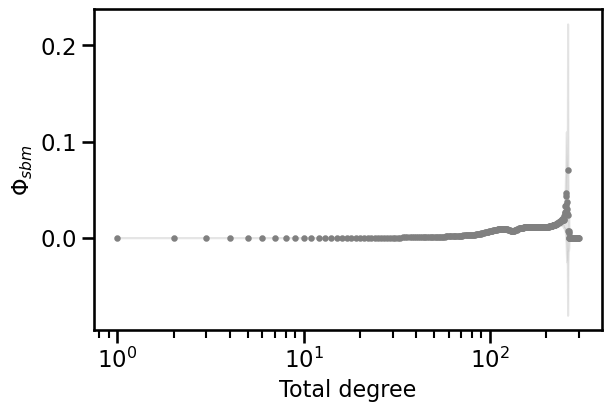

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["total-sbm"], axis=0)
stddevs = np.std(rich_club_coefficients["total-sbm"], axis=0)
ax.scatter(degrees, means, s=10, color=colors['sbm'])
ax.fill_between(degrees, means - stddevs, means + stddevs, color=colors['sbm'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('Total degree', fontsize=16)
ax.set_ylabel('$\Phi_{sbm}$', fontsize=16)
plt.savefig("figs/total-degree-phi-sbm.pdf", transparent=True)

### 7.2 more plots for comparison

obs vs sbm

In [152]:
total_degrees = g.degree_property_map("total") 
degrees = sorted(np.unique(total_degrees.a))
degrees_sbm = np.arange(1, 300)

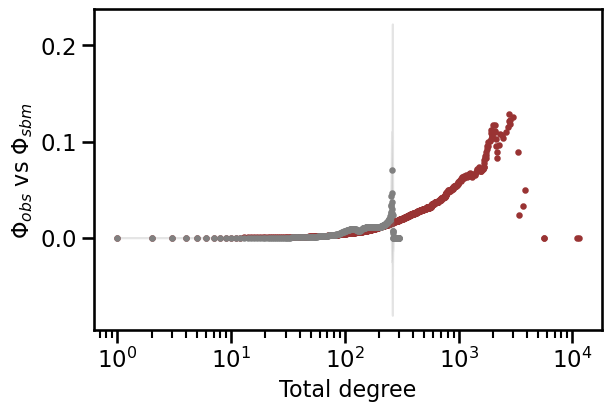

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
means = np.mean(rich_club_coefficients["total-sbm"], axis=0)
stddevs = np.std(rich_club_coefficients["total-sbm"], axis=0)
ax.scatter(degrees, rich_club_coefficients["total"], s=10, color=colors['obs'])
ax.scatter(degrees_sbm, means, s=10, color=colors['sbm'])
ax.fill_between(degrees_sbm, means - stddevs, means + stddevs, color=colors['sbm'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('Total degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs}$ vs $\Phi_{sbm}$', fontsize=16)
plt.savefig("figs/total-degree-phi-obs-vs-sbm.pdf", transparent=True)

In [158]:
degrees = np.array(degrees)
mask_degree = np.array([d in degrees_sbm for d in degrees])

In [159]:
degrees_sbm = np.array(degrees_sbm)
mask_degree_sbm = np.array([d in degrees for d in degrees_sbm])

In [163]:
colors['rel-sbm'] = 'gray'

/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/3961447415.py:4: RuntimeWarning: divide by zero encountered in divide
  rel_phi = obs_mean[mask_degree] / means[mask_degree_sbm]
/var/folders/lq/1wn16kmd2k1g0rjr_hy10kvr0000gn/T/ipykernel_1025/3961447415.py:5: RuntimeWarning: divide by zero encountered in divide
  stddevs = np.std(obs_mean[mask_degree] / rich_club_coefficients["total-sbm"][:, mask_degree_sbm], axis=0)
/Users/YRZ/miniconda3/envs/gt/lib/python3.11/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


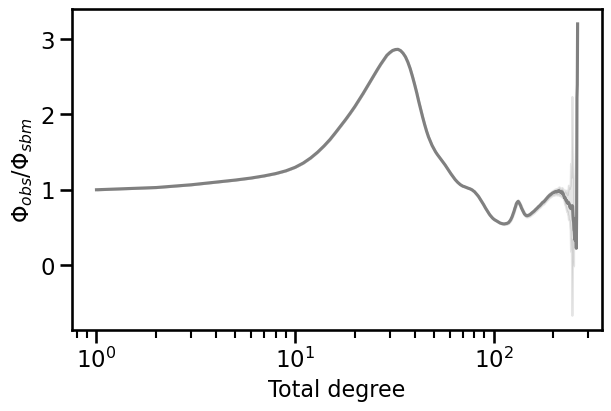

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
obs_mean = np.array(rich_club_coefficients["total"])
means = np.mean(rich_club_coefficients["total-sbm"], axis=0)
rel_phi = obs_mean[mask_degree] / means[mask_degree_sbm]
stddevs = np.std(obs_mean[mask_degree] / rich_club_coefficients["total-sbm"][:, mask_degree_sbm], axis=0)
ax.plot(degrees[mask_degree], rel_phi, color=colors['rel-sbm'])
ax.fill_between(degrees[mask_degree], rel_phi - stddevs, rel_phi + stddevs, color=colors['rel-sbm'], alpha=0.2)  # Shaded std dev
ax.set_xscale('log')
ax.set_xlabel('Total degree', fontsize=16)
ax.set_ylabel('$\Phi_{obs} / \Phi_{sbm}$', fontsize=16)
plt.savefig("figs/total-degree-phi-rel-sbm.pdf", transparent=True)